Goals of this analysis: 
- Create **rolling mean** of data to smooth out some variation
- Make separate **linear regressions** for distinct treatment periods

In [3]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [29]:
data=pd.read_excel('PerformanceDataFake.xlsx')
data.head(n=15)

,Subject,Measure1,Measure2,Measure3,Measure4,Measure5,TestPhase,SessionLabel2,SessionLabel,LastTreatmentSession,InTreatmentSessionNumber
0,1,95,14,3,93,39,-1,P1,P6,0,NaN
1,1,28,15,51,54,28,-1,P2,P5,0,NaN
2,1,70,77,13,35,63,-1,P3,P4,0,NaN
3,1,5,65,45,62,50,-1,P4,P3,0,NaN
4,1,38,62,76,53,63,-1,P5,P2,0,NaN
5,1,25,85,29,4,75,-1,P6,P1,0,NaN
6,1,56,23,20,64,43,0,F1,F4,0,1.0
7,1,84,7,49,26,64,0,F2,F3,0,2.0
8,1,33,56,37,51,81,0,F3,F2,0,3.0
9,1,70,59,33,27,72,0,F4,F1,1,4.0


Each row is one trial for one subject. Several measures are taken, and metadata is included to denote whether this trial occured before treatment began, during treatment, or after treatment ended.

In [31]:
#Sanitize the inputs a little
df = data

#for this analysis, we don't need post-treatment -- remove it
df = df[df['SessionLabel2'].str.contains('R1')==False] 

#For our linear regression, we need NaNs replaced with 0
df['InTreatmentSessionNumber'].fillna(0,inplace=True)

#And change TestPhase from -1,0 to 0,1
df = df.assign(TestPhase = [0 if TestPhase == -1 else 1 for TestPhase in df['TestPhase']]) #Convert the -1 to 0

#We want a test session number for each session by subject
df.reset_index() #make sure index corresponds to row
sessNum=[]
prevSub=0
for ind,row in df.iterrows():
    #if prevSub == df.loc[ind,'Subject']:
    if prevSub == df['Subject'][ind]:
        count+=1
    else:
        count=1
    sessNum.append(count)
    prevSub=df['Subject'][ind]

#assign
df = df.assign(TestSessionNo = sessNum)



#Variables to loop through
subjects=df['Subject'].unique()
measures=['Measure1','Measure2','Measure3','Measure4','Measure5']

C:\Users\andre\AppData\Local\Temp\ipykernel_24584\98631061.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InTreatmentSessionNumber'].fillna(0,inplace=True)


The above warning is a false positive **(** and can be disabled with pd.set_option('mode.chained_assignment',None) **)**

We need to make two functions now -- one to implement a rolling mean, and one to plot our data and fit lines

In [24]:
def rolling_plot_AT(sub,measure,noplot=False): 

    
    # get a rolling mean (each point is avgd with point before it)
    rmean = sub[measure].rolling(window=2).mean() #getting rolling mean
    
    #But we have two problems -- we want to keep our first time point (it will remain unchanged), and
    #   we don't want to average timepoints from different treatment phases together.
    
    #HERE, I replace first point with first point (instead of NAN)
    rmean.loc[sub['SessionLabel2'] == 'P1']=sub.loc[sub['SessionLabel2'] == 'P1',measure] 
    
    # replace first in-treatment point that is avgd with pre-treatment with first in-treatment (not averaged)
    rmean.loc[sub['SessionLabel2'] == 'F1']=sub.loc[sub['SessionLabel2'] == 'F1',measure]
    
    # plot rolling mean
    if not noplot:
        plt.figure(figsize=(10,6))
        orig = plt.plot(sub[measure], color='black',label='Original', marker='.')
        mean = plt.plot(rmean, color='red',label='Rolling Mean', marker='.')
        plt.legend(loc='best')
        plt.title("Rolling mean")
        plt.show(block=False)
    
    return rmean

In [32]:
# Get model predictions and 95% confidence interval
def counterfactual_plot_AT(res, df, measure1): 
    start = df.loc[df['TestPhase']==1].index[0]
    end = df.loc[df['TestPhase']==1].index[-1]
    beta = res.params
    predictions = res.get_prediction(df) 
    summary = predictions.summary_frame(alpha=0.05)

    # mean predictions
    y_pred = predictions.predicted_mean

    # countefactual assumes no interventions
    cf_df = df.copy()
    cf_df["TestPhase"] = 0.0
    cf_df["InTreatmentSessionNumber"] = 0.0

    # counter-factual predictions
    cf = res.get_prediction(cf_df).summary_frame(alpha=0.05)

    # Plotting
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(16,10))

    # Plot bounce rate data
    ax.scatter(df["TestSessionNo"], df['rmean_'+measure1], facecolors='none', edgecolors='steelblue', label='Moving Avg '+measure1+' Score', linewidths=2)

    # Plot model mean bounce rate prediction
    ax.plot(df["TestSessionNo"][:start], y_pred[:start], 'b-', label="model prediction")
    ax.plot(df["TestSessionNo"][start:], y_pred[start:], 'b-')

    # Plot counterfactual mean bounce rate with 95% confidence interval
    ax.plot(df["TestSessionNo"][start:], cf['mean'][start:], 'k.', label="counterfactual")
    ax.fill_between(df["TestSessionNo"][start:], cf['mean_ci_lower'][start:], cf['mean_ci_upper'][start:], color='k', alpha=0.1, label="counterfactual 95% CI");

    # Plot line marking intervention moment
    ax.axvline(x = start+1, color = 'r', label = 'intervention')

    ax.legend(loc='best')
    #plt.ylim([10, 15])
    plt.xlabel("Test Session")
    plt.ylabel(measure1)
    plt.show()
    
    

Now it's time to create fit lines for our treatment conditions and plot these for each subject/measure

   Subject  Measure1  Measure2  Measure3  Measure4  Measure5  TestPhase  \
0        1        95        14         3        93        39          0   
1        1        28        15        51        54        28          0   
2        1        70        77        13        35        63          0   
3        1         5        65        45        62        50          0   
4        1        38        62        76        53        63          0   
5        1        25        85        29         4        75          0   
6        1        56        23        20        64        43          1   
7        1        84         7        49        26        64          1   
8        1        33        56        37        51        81          1   
9        1        70        59        33        27        72          1   

  SessionLabel2 SessionLabel  LastTreatmentSession  InTreatmentSessionNumber  \
0            P1           P6                     0                       0.0   
1            P

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


                            OLS Regression Results                            
Dep. Variable:         rmean_Measure1   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     8.456
Date:                Wed, 16 Aug 2023   Prob (F-statistic):             0.0142
Time:                        22:57:20   Log-Likelihood:                -35.720
No. Observations:                  10   AIC:                             79.44
Df Residuals:                       6   BIC:                             80.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

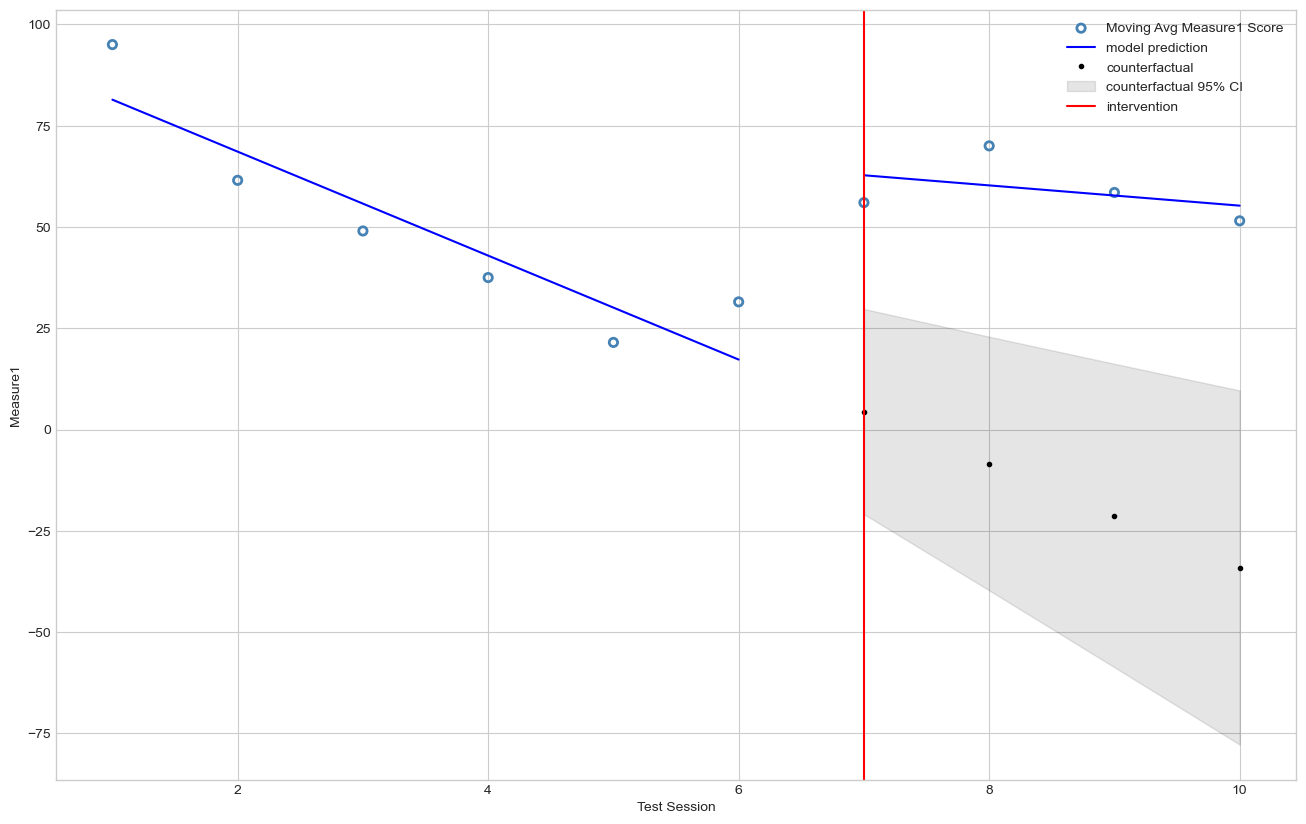

using measure Measure2
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure2   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     10.46
Date:                Wed, 16 Aug 2023   Prob (F-statistic):            0.00849
Time:                        22:57:20   Log-Likelihood:                -36.391
No. Observations:                  10   AIC:                             80.78
Df Residuals:                       6   BIC:                             81.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


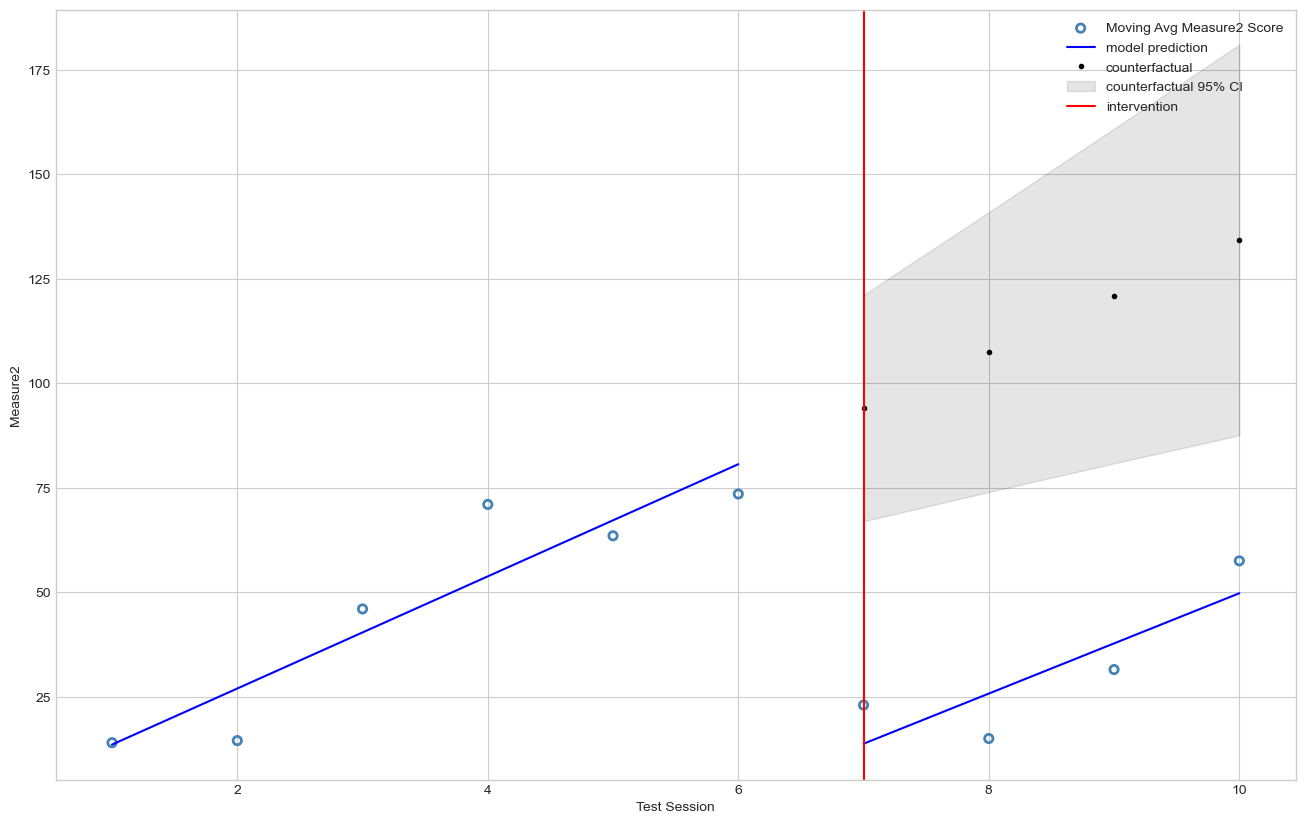

using measure Measure3
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure3   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     7.163
Date:                Wed, 16 Aug 2023   Prob (F-statistic):             0.0208
Time:                        22:57:21   Log-Likelihood:                -33.899
No. Observations:                  10   AIC:                             75.80
Df Residuals:                       6   BIC:                             77.01
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


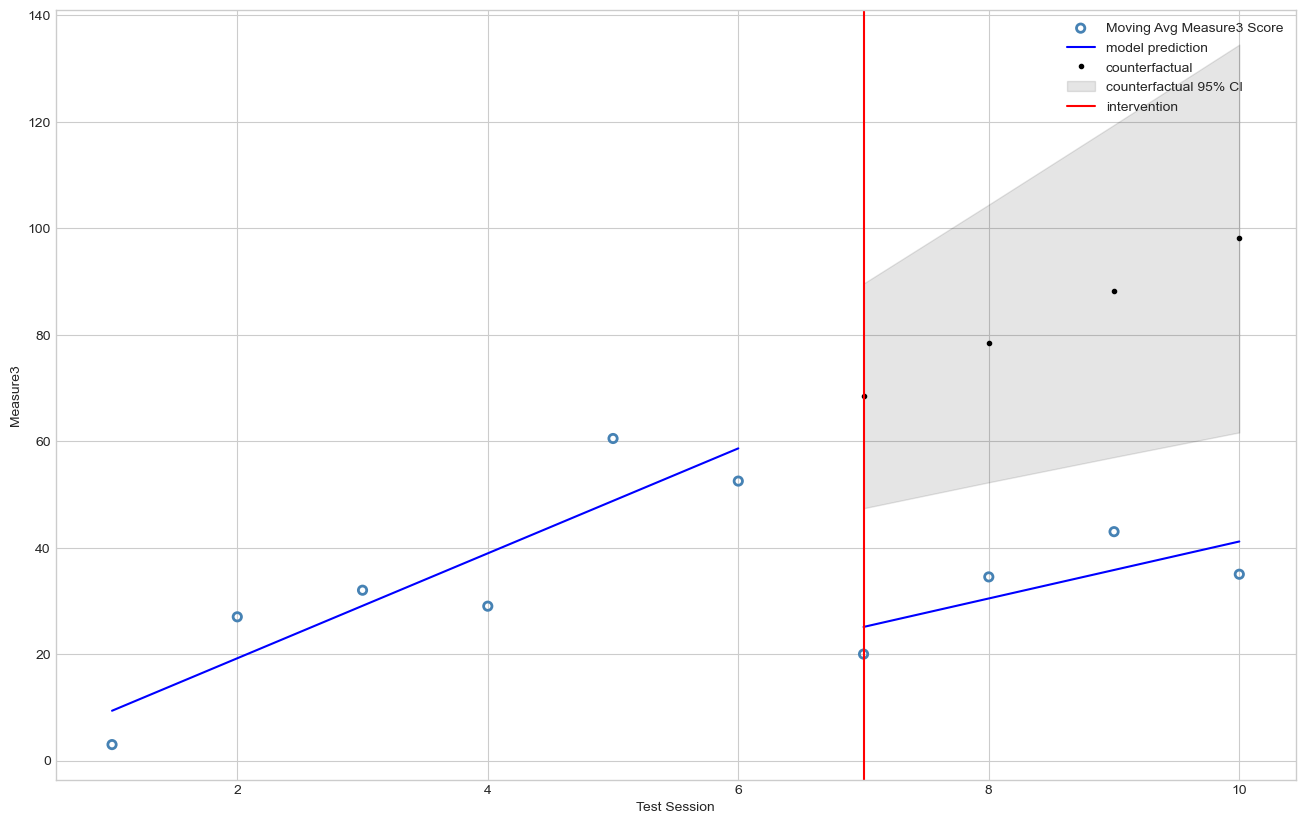

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


using measure Measure4
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure4   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     6.470
Date:                Wed, 16 Aug 2023   Prob (F-statistic):             0.0261
Time:                        22:57:21   Log-Likelihood:                -36.004
No. Observations:                  10   AIC:                             80.01
Df Residuals:                       6   BIC:                             81.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


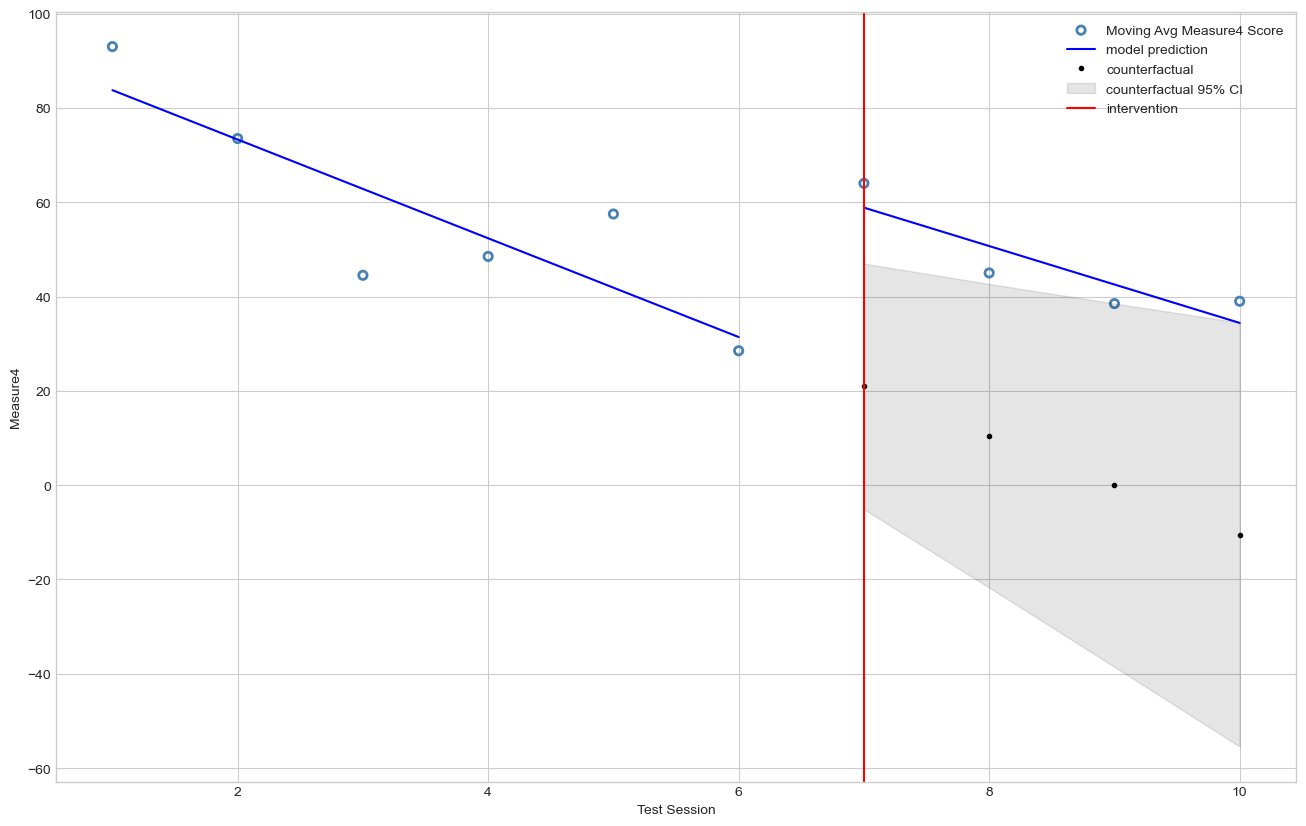

using measure Measure5


D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


                            OLS Regression Results                            
Dep. Variable:         rmean_Measure5   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     25.17
Date:                Wed, 16 Aug 2023   Prob (F-statistic):           0.000848
Time:                        22:57:21   Log-Likelihood:                -27.437
No. Observations:                  10   AIC:                             62.87
Df Residuals:                       6   BIC:                             64.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

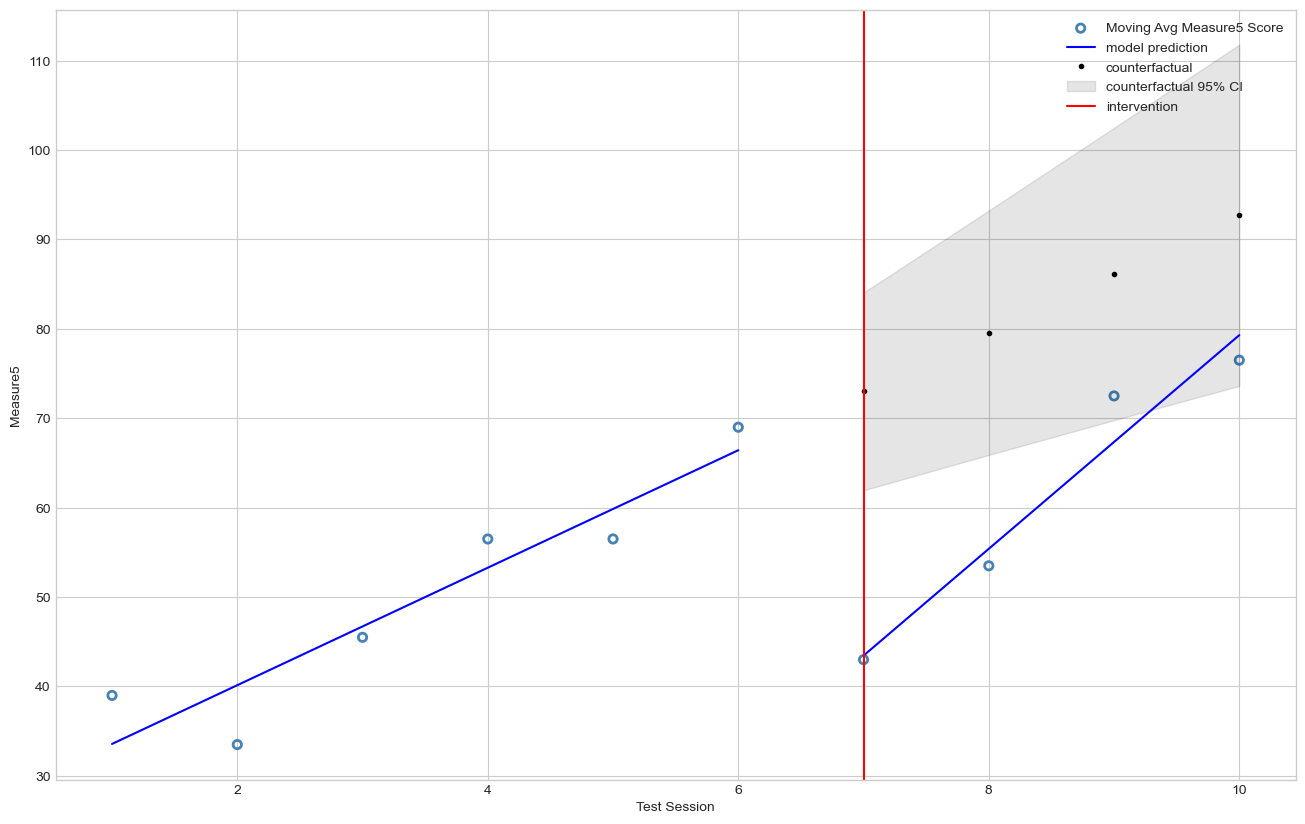

    Subject  Measure1  Measure2  Measure3  Measure4  Measure5  TestPhase  \
11        2        46        38        65        40        36          0   
12        2        85        73        51        66        62          0   
13        2        72        37        68        33        55          0   
14        2        91        88        91        79        83          0   
15        2        73        54        48        29        18          0   
16        2        95        23        54        96        67          0   
17        2         1        21        50        72        58          1   
18        2        79        77        27        71         5          1   

   SessionLabel2 SessionLabel  LastTreatmentSession  InTreatmentSessionNumber  \
11            P1           P6                     0                       0.0   
12            P2           P5                     0                       0.0   
13            P3           P4                     0                     

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


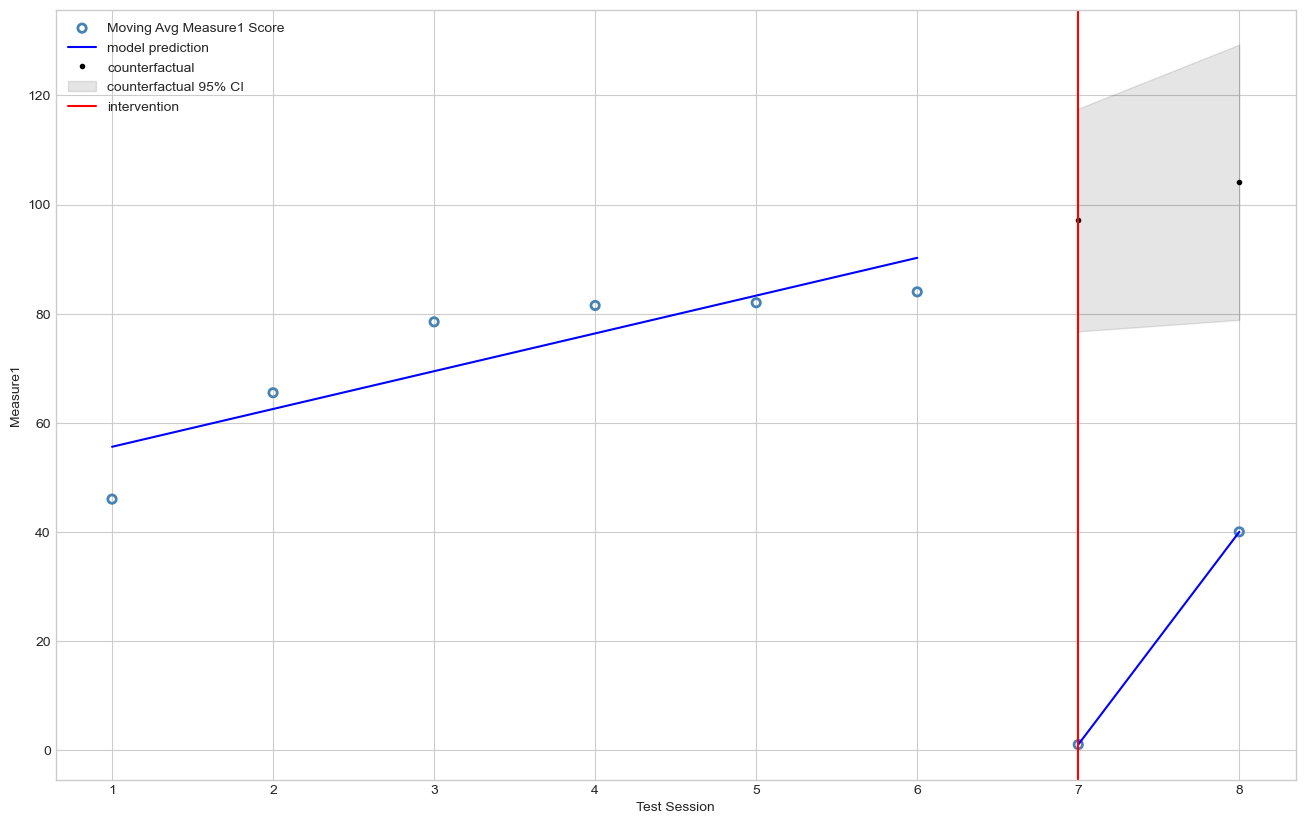

using measure Measure2
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure2   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     1.552
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.332
Time:                        22:57:21   Log-Likelihood:                -29.837
No. Observations:                   8   AIC:                             67.67
Df Residuals:                       4   BIC:                             67.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


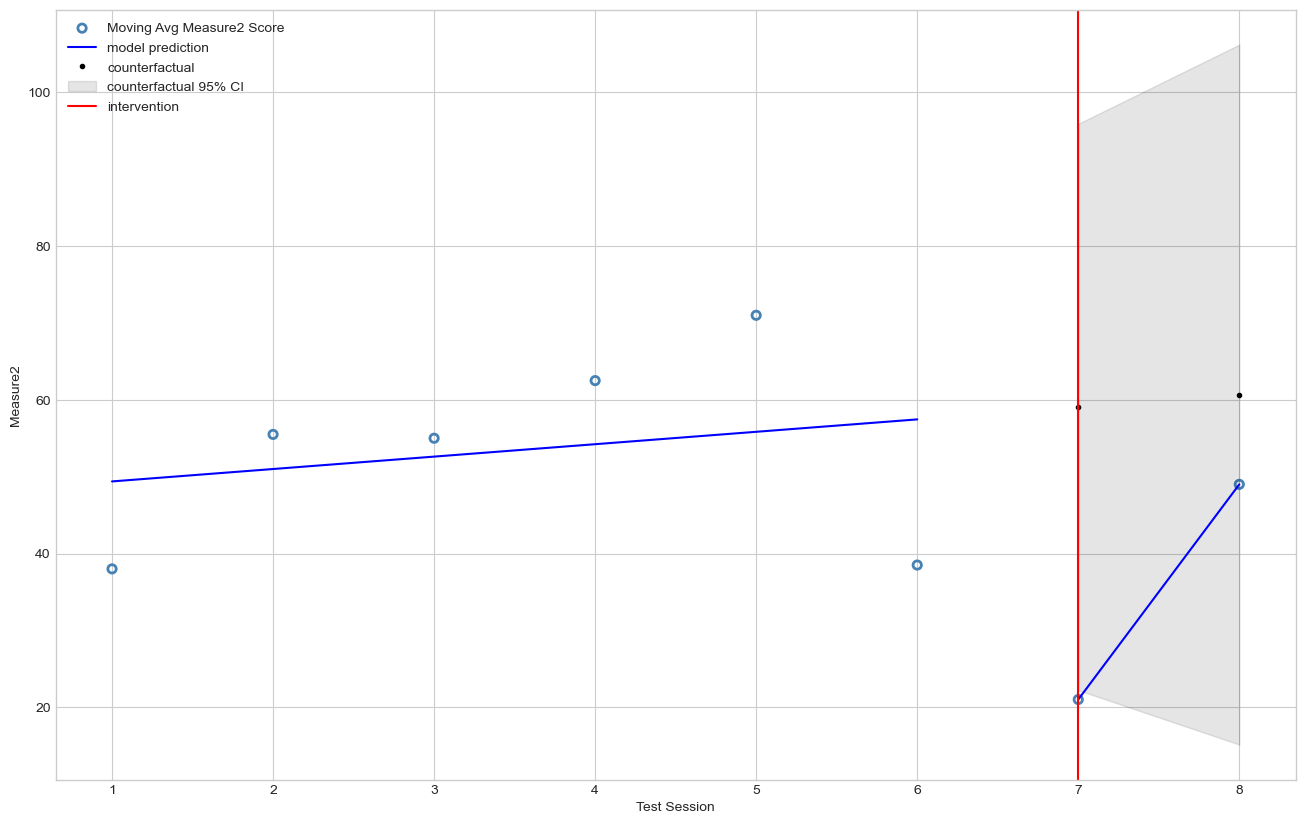

using measure Measure3
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure3   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     1.731
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.298
Time:                        22:57:21   Log-Likelihood:                -27.835
No. Observations:                   8   AIC:                             63.67
Df Residuals:                       4   BIC:                             63.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


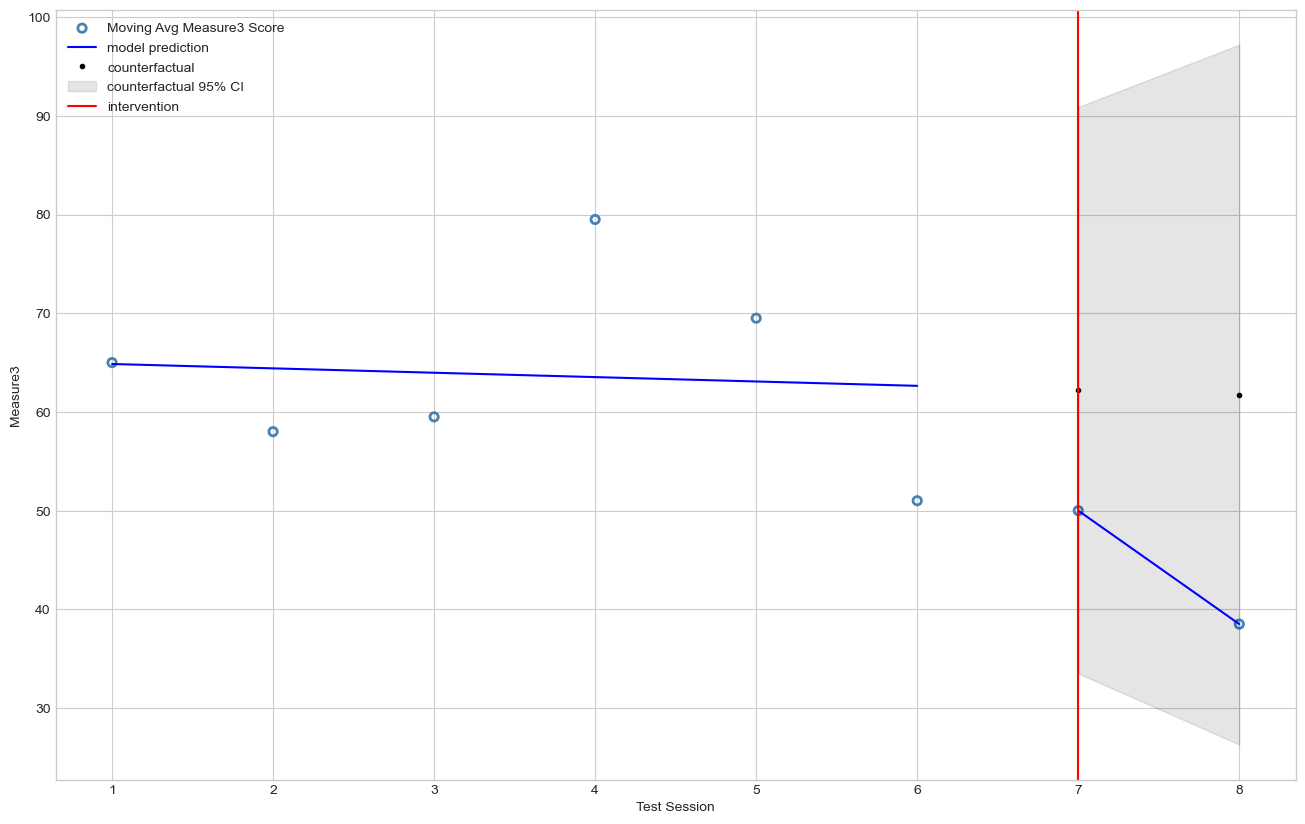

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


using measure Measure4
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure4   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     15.21
Date:                Wed, 16 Aug 2023   Prob (F-statistic):             0.0118
Time:                        22:57:22   Log-Likelihood:                -19.875
No. Observations:                   8   AIC:                             47.75
Df Residuals:                       4   BIC:                             48.07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

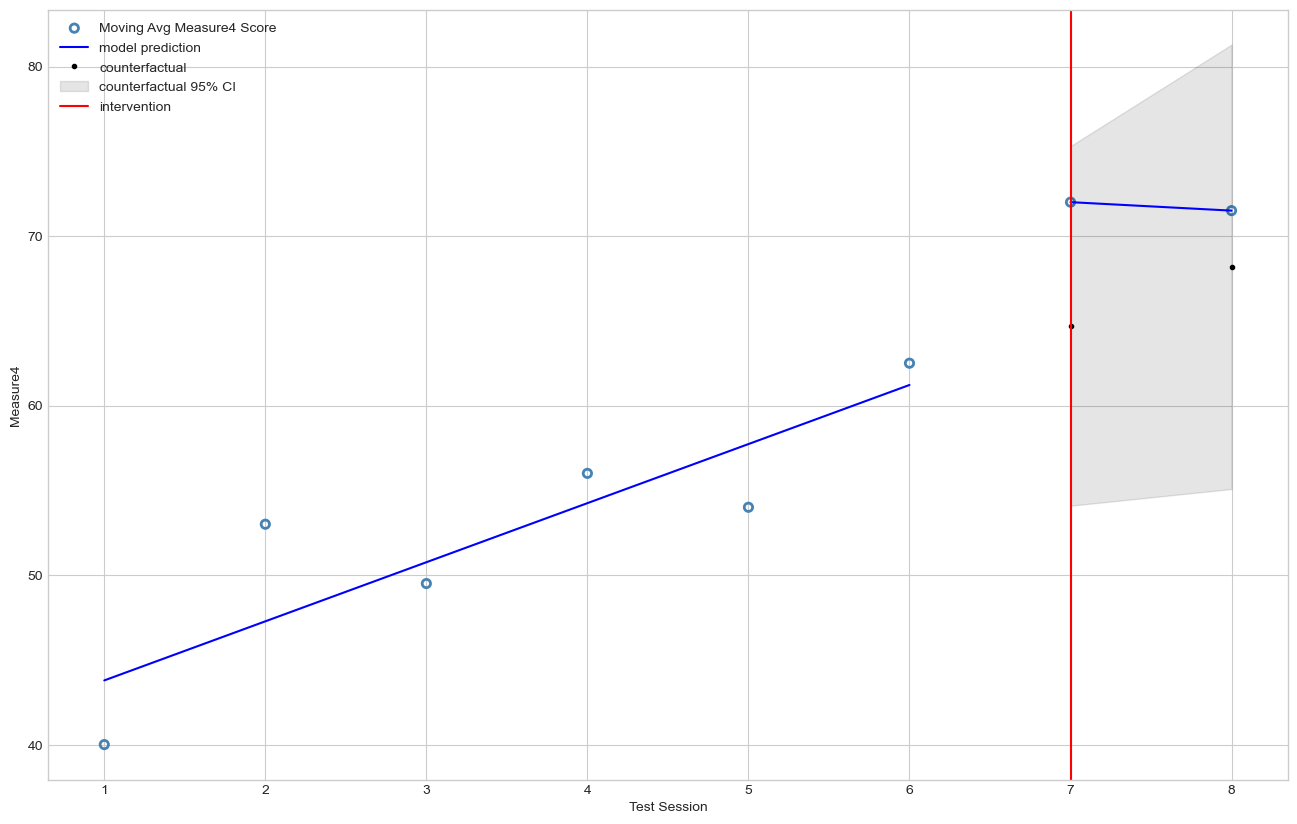

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


using measure Measure5
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure5   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.9041
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.514
Time:                        22:57:22   Log-Likelihood:                -28.938
No. Observations:                   8   AIC:                             65.88
Df Residuals:                       4   BIC:                             66.19
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


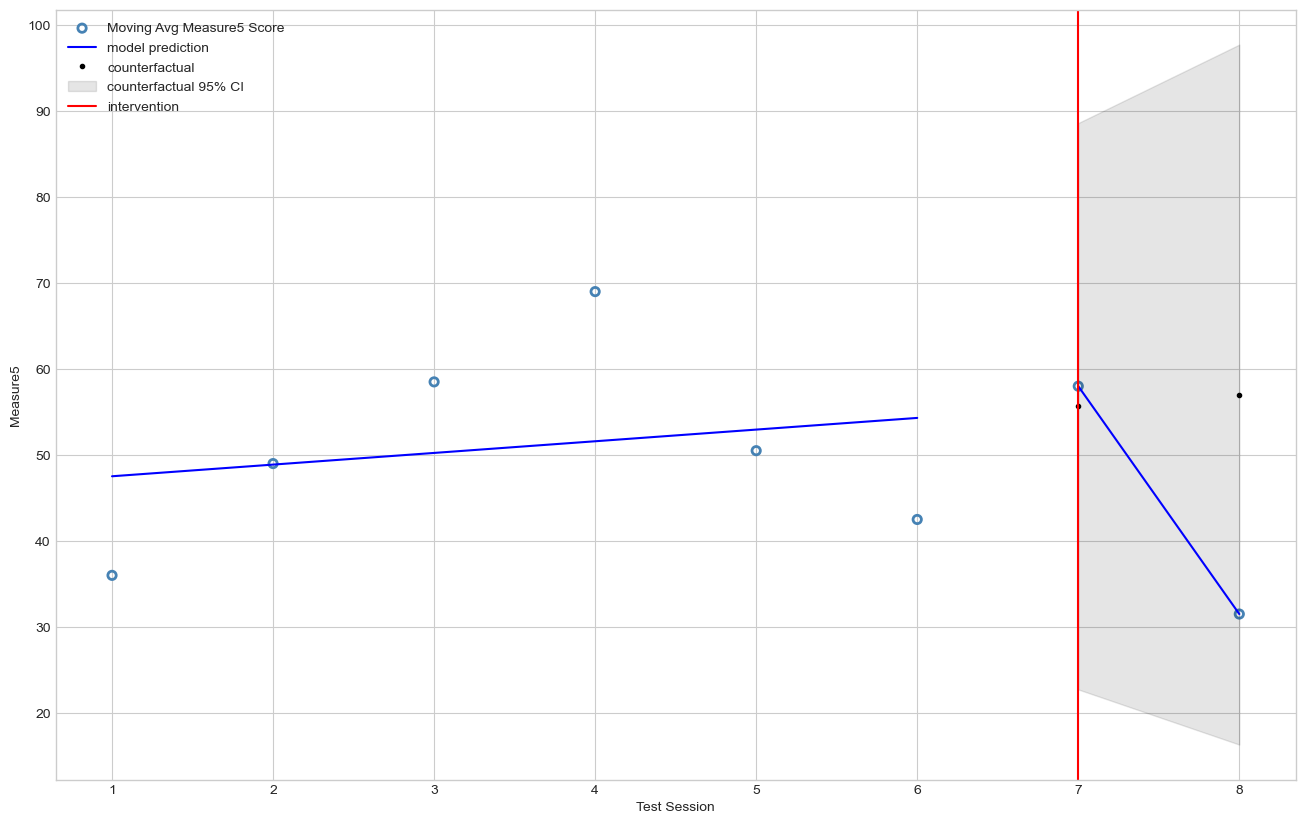

    Subject  Measure1  Measure2  Measure3  Measure4  Measure5  TestPhase  \
20        3        63        81        35        60        41          0   
21        3        35        81        40        71        21          0   
22        3         5        99        54        14        73          0   
23        3        93        80        57        52        12          0   
24        3        51        76        66        10        98          0   
25        3        63        70        17        41        59          0   
26        3        37        14        65        73         7          1   
27        3        20        94        30        39        41          1   
28        3         2        65        56        38        51          1   
29        3        66        87        38        92        14          1   

   SessionLabel2 SessionLabel  LastTreatmentSession  InTreatmentSessionNumber  \
20            P1           P6                     0                       0.0   
2

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


                            OLS Regression Results                            
Dep. Variable:         rmean_Measure1   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     1.573
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.291
Time:                        22:57:22   Log-Likelihood:                -40.403
No. Observations:                  10   AIC:                             88.81
Df Residuals:                       6   BIC:                             90.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

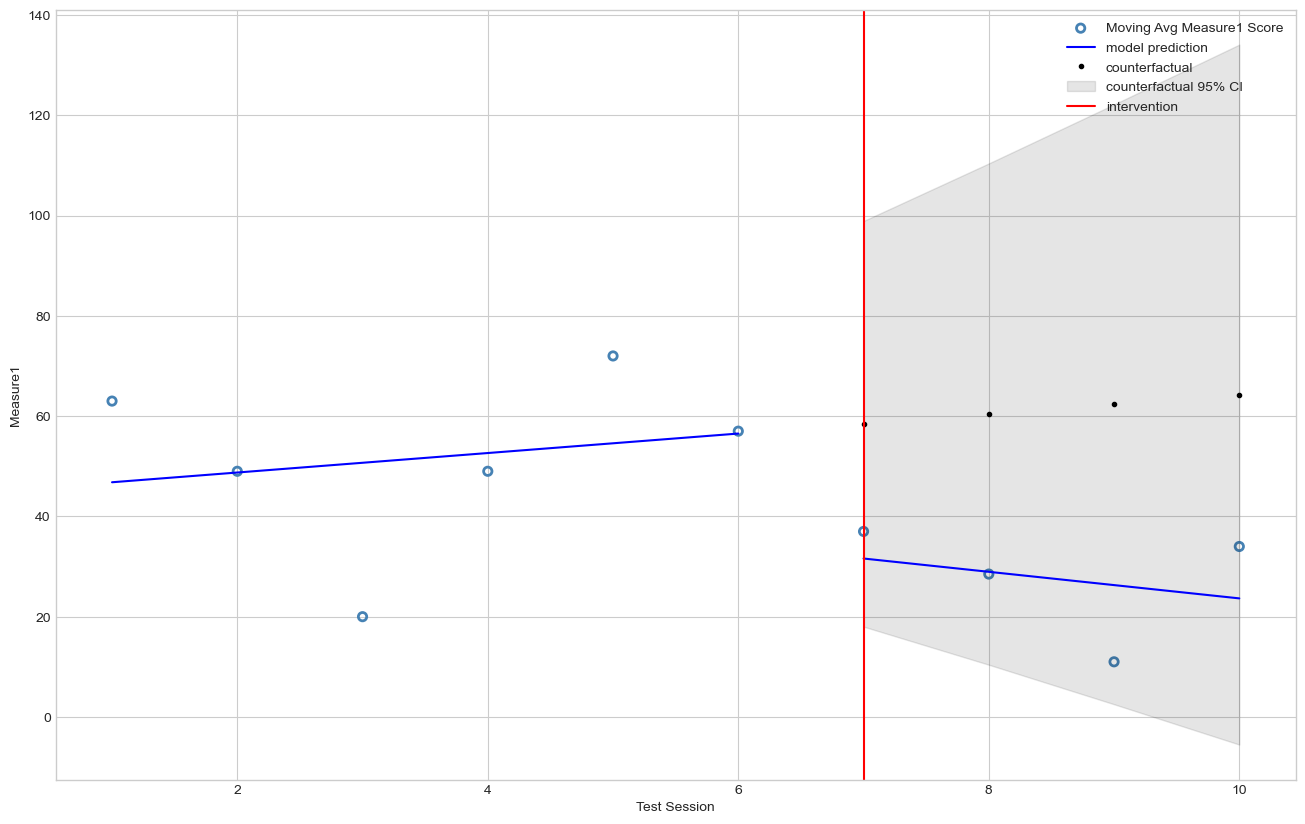

using measure Measure2
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure2   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     11.74
Date:                Wed, 16 Aug 2023   Prob (F-statistic):            0.00637
Time:                        22:57:22   Log-Likelihood:                -35.196
No. Observations:                  10   AIC:                             78.39
Df Residuals:                       6   BIC:                             79.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


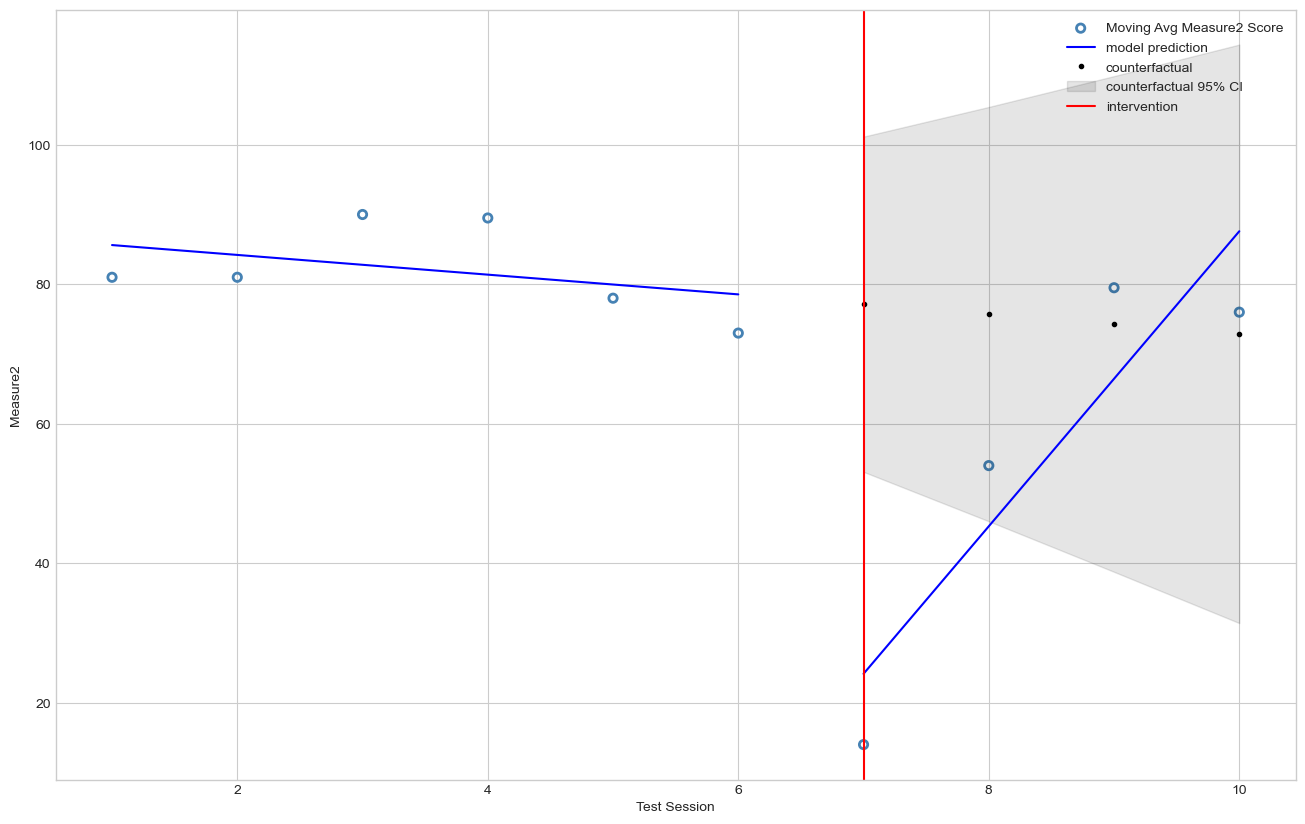

using measure Measure3
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure3   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     1.662
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.273
Time:                        22:57:22   Log-Likelihood:                -33.530
No. Observations:                  10   AIC:                             75.06
Df Residuals:                       6   BIC:                             76.27
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


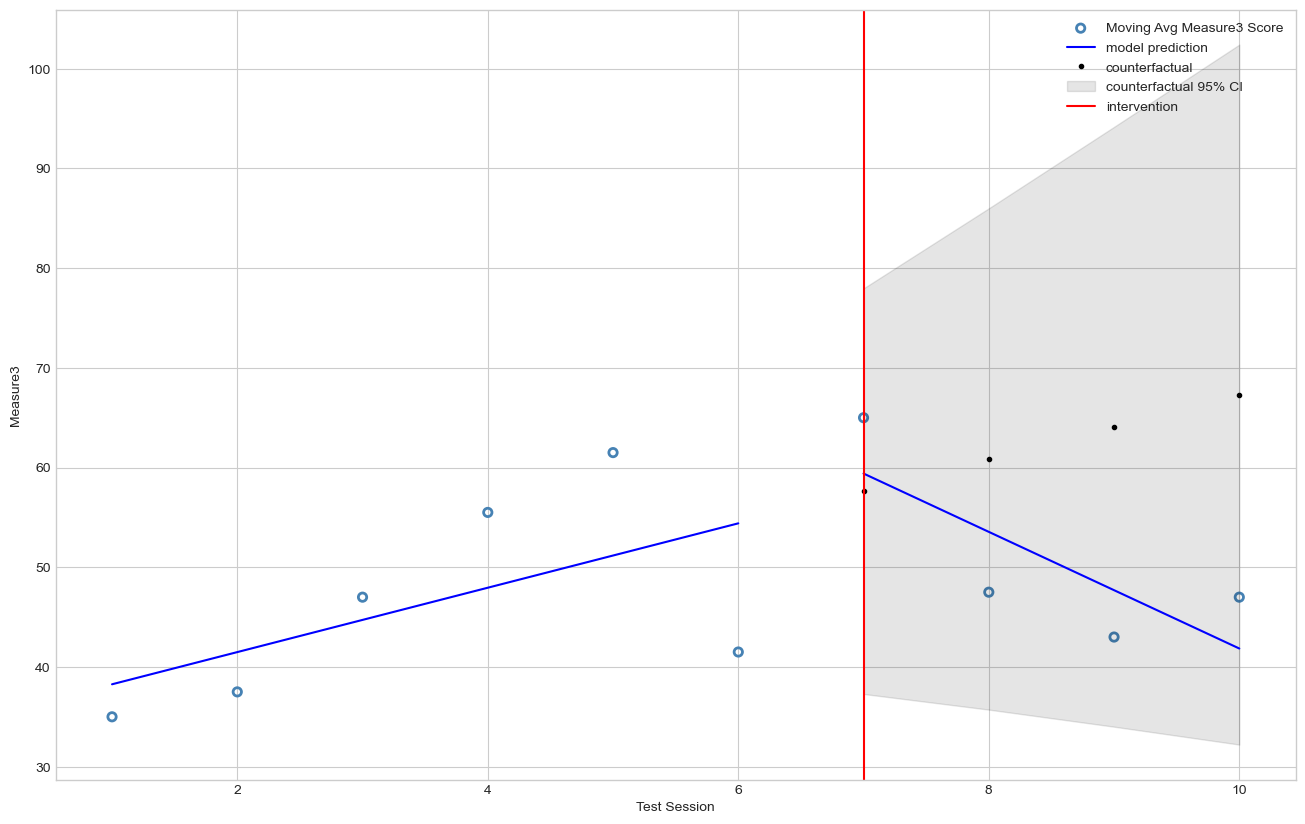

using measure Measure4
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure4   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     4.794
Date:                Wed, 16 Aug 2023   Prob (F-statistic):             0.0492
Time:                        22:57:22   Log-Likelihood:                -35.799
No. Observations:                  10   AIC:                             79.60
Df Residuals:                       6   BIC:                             80.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


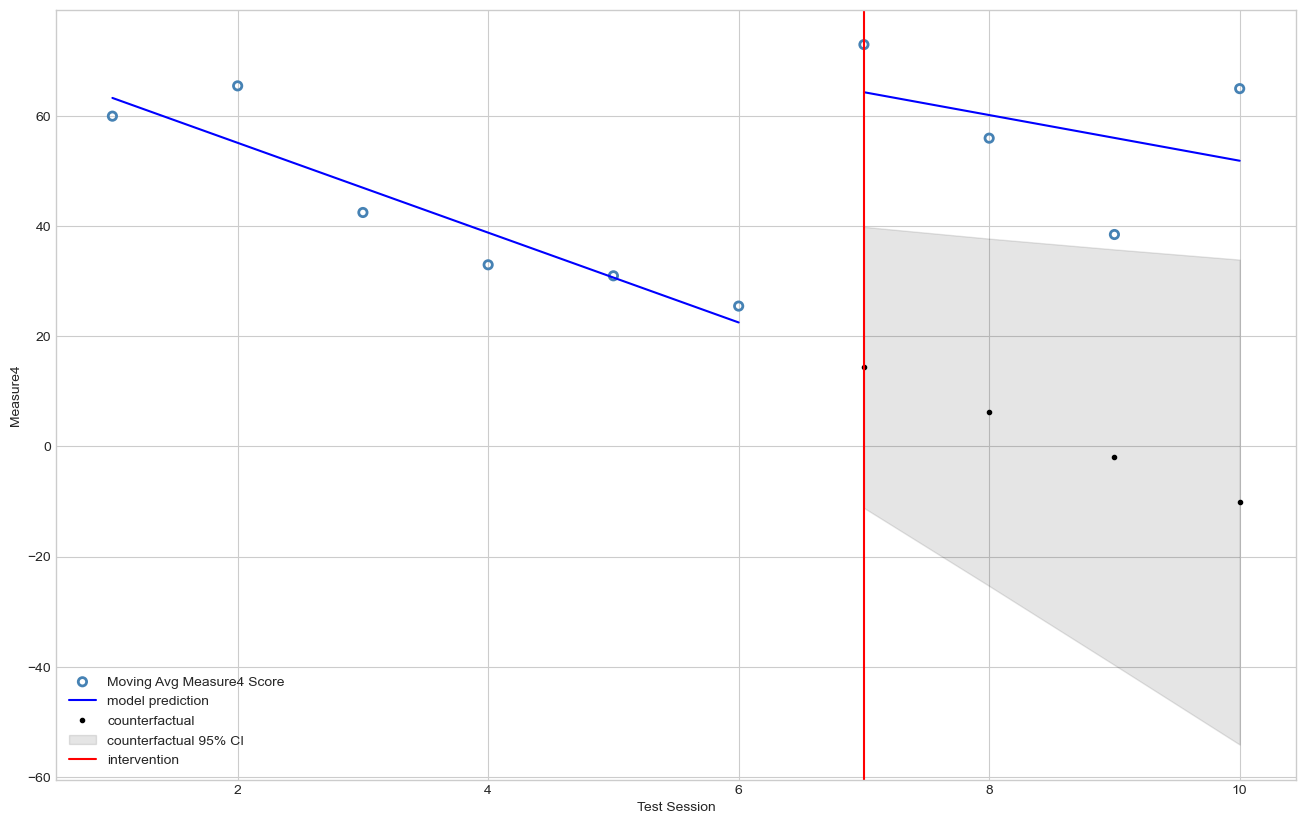

using measure Measure5
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure5   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     7.035
Date:                Wed, 16 Aug 2023   Prob (F-statistic):             0.0217
Time:                        22:57:23   Log-Likelihood:                -35.614
No. Observations:                  10   AIC:                             79.23
Df Residuals:                       6   BIC:                             80.44
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


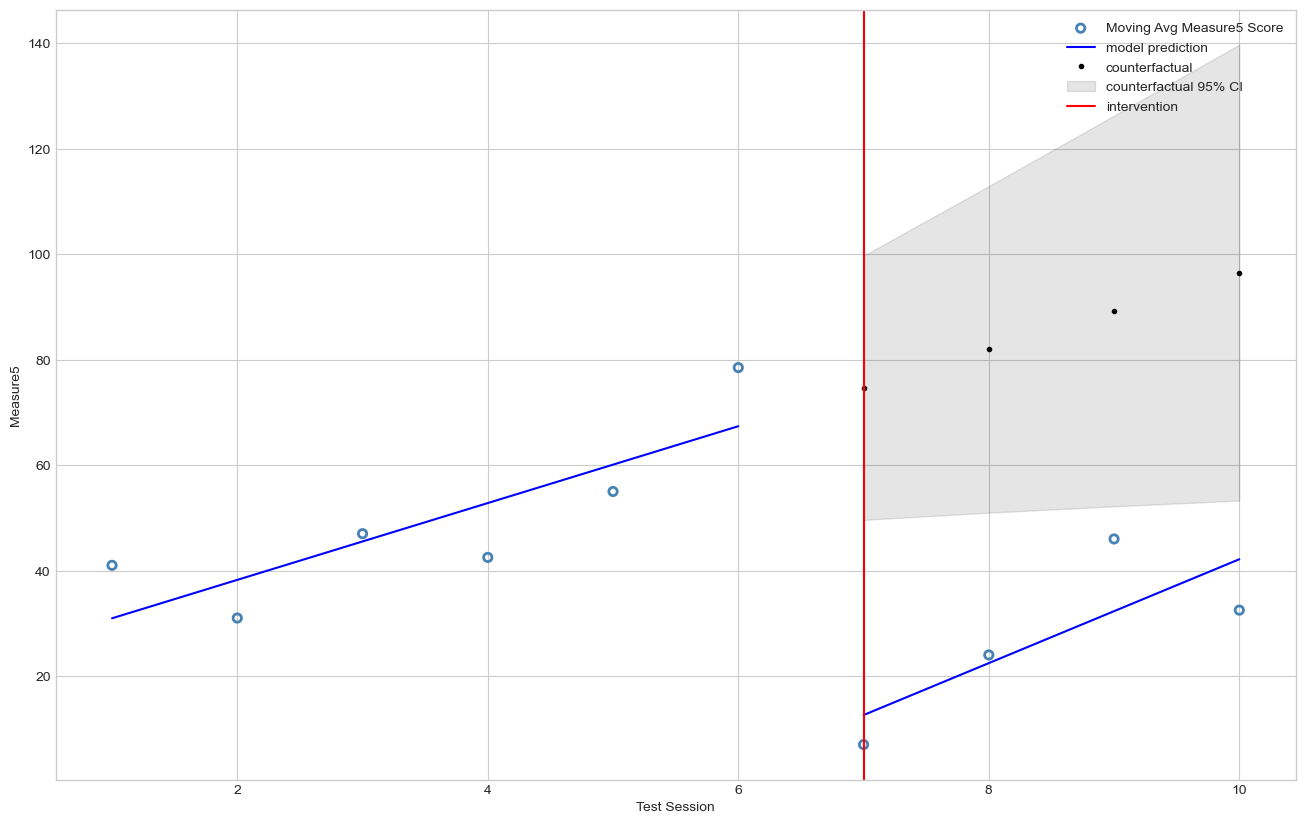

    Subject  Measure1  Measure2  Measure3  Measure4  Measure5  TestPhase  \
31        4         3        29        34        24        83          0   
32        4        10        69        57        64         2          0   
33        4        65        61        46        31        63          0   
34        4        15        91        10        65         2          0   
35        4         4        32        24        33        85          0   
36        4        96        17        55        74        93          0   
37        4         5        47        91        79        65          1   
38        4        72        56        24        57         2          1   
39        4        86        25        42        94        10          1   
40        4         3        41        84        59        42          1   
41        4        75        33        23        89        24          1   

   SessionLabel2 SessionLabel  LastTreatmentSession  InTreatmentSessionNumber  \
31    

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')



using measure Measure1
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure1   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     1.491
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.298
Time:                        22:57:23   Log-Likelihood:                -47.171
No. Observations:                  11   AIC:                             102.3
Df Residuals:                       7   BIC:                             103.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------


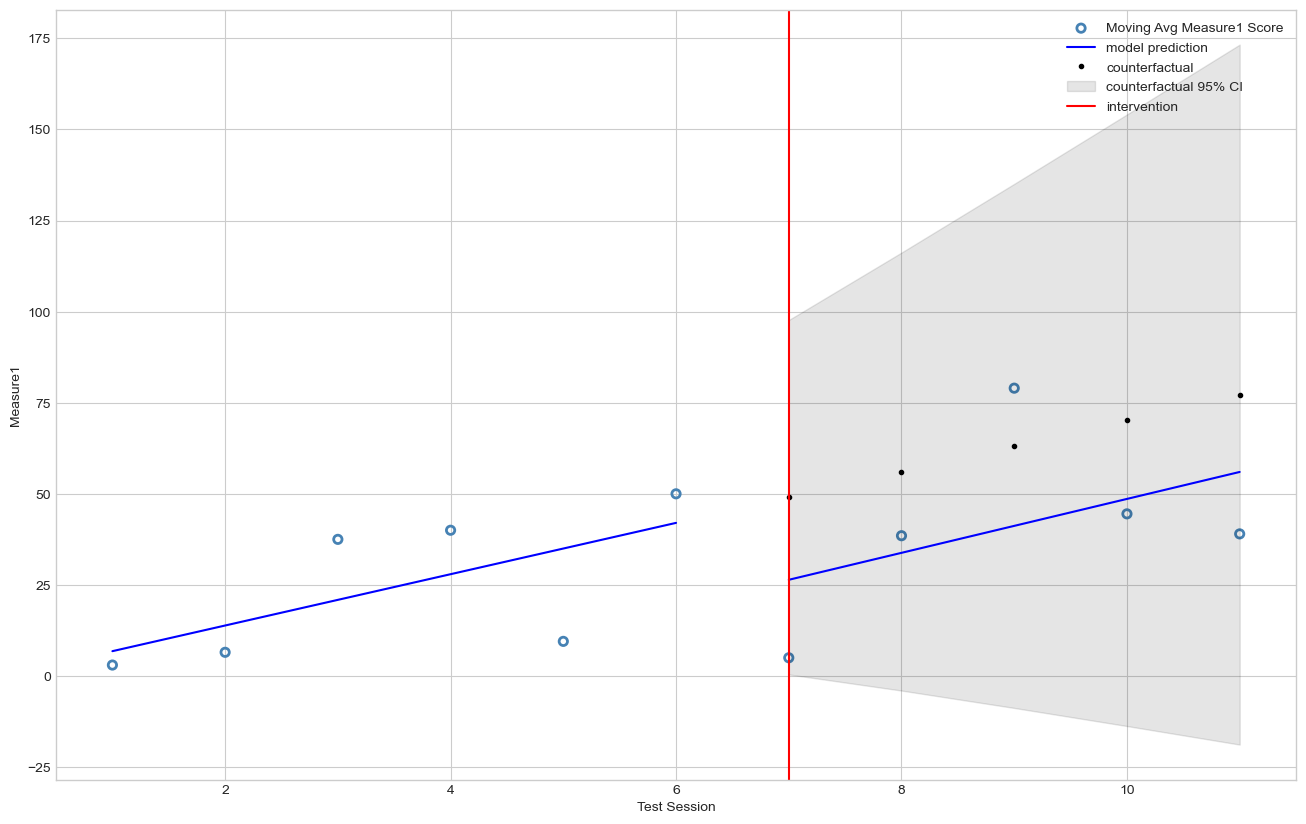

using measure Measure2
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure2   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                 -0.217
Method:                 Least Squares   F-statistic:                    0.4059
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.754
Time:                        22:57:23   Log-Likelihood:                -44.716
No. Observations:                  11   AIC:                             97.43
Df Residuals:                       7   BIC:                             99.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


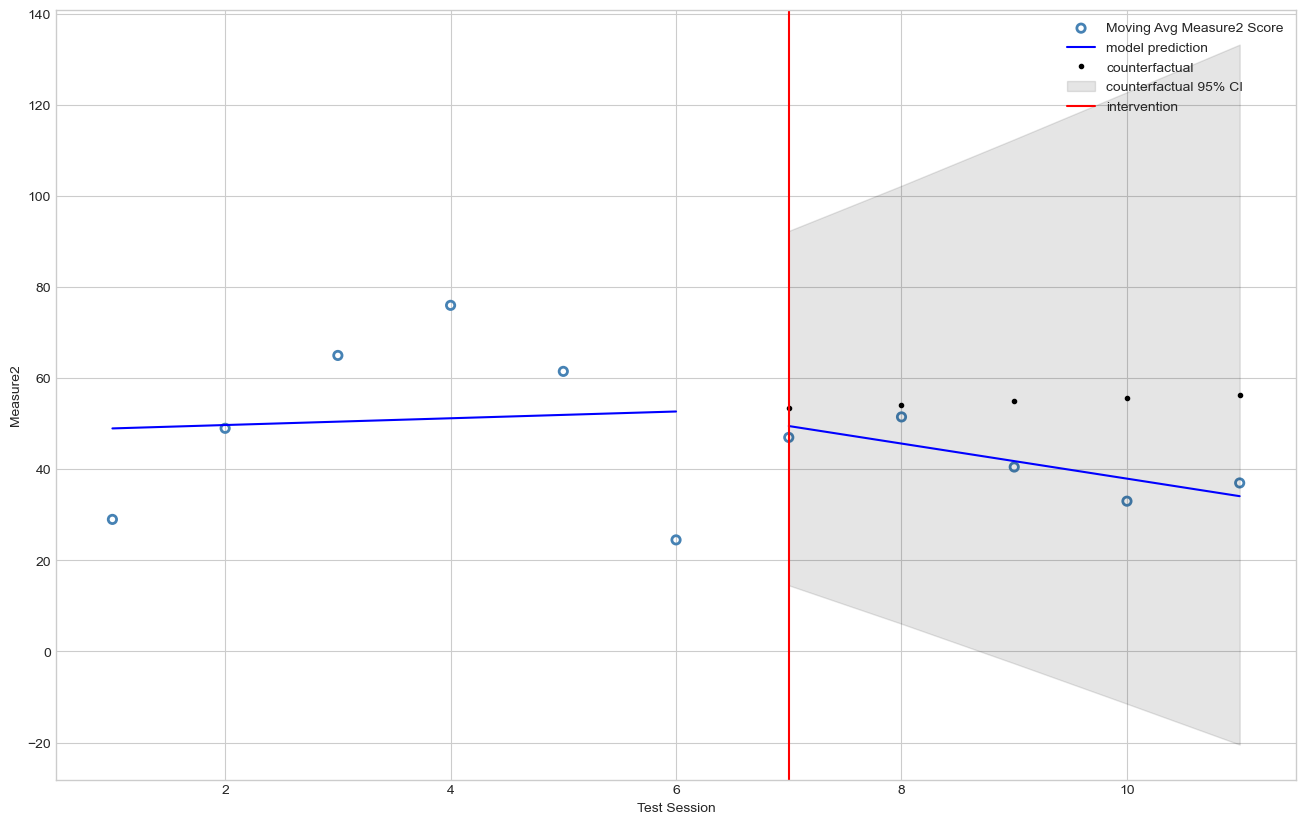

using measure Measure3
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure3   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     2.534
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.140
Time:                        22:57:23   Log-Likelihood:                -44.059
No. Observations:                  11   AIC:                             96.12
Df Residuals:                       7   BIC:                             97.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


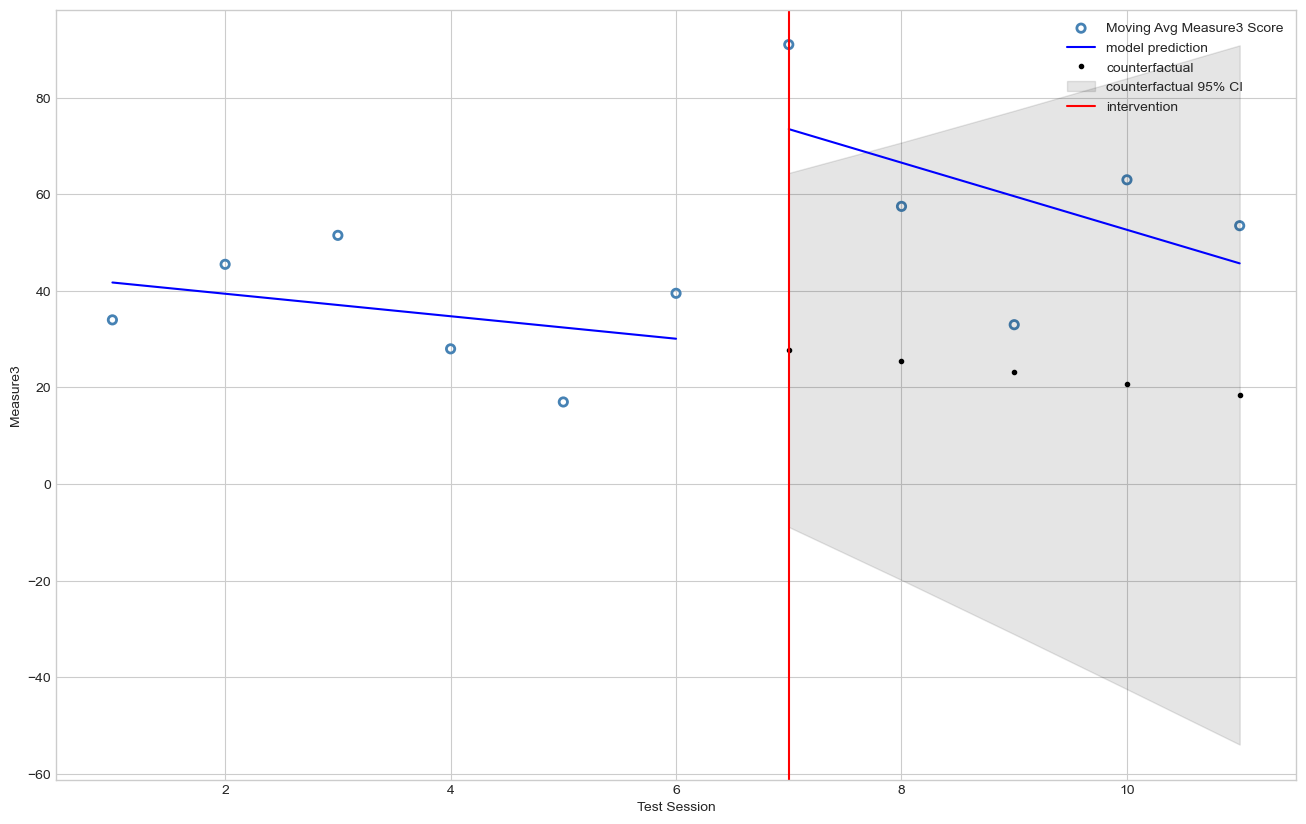

using measure Measure4
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure4   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     29.10
Date:                Wed, 16 Aug 2023   Prob (F-statistic):           0.000252
Time:                        22:57:23   Log-Likelihood:                -32.347
No. Observations:                  11   AIC:                             72.69
Df Residuals:                       7   BIC:                             74.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


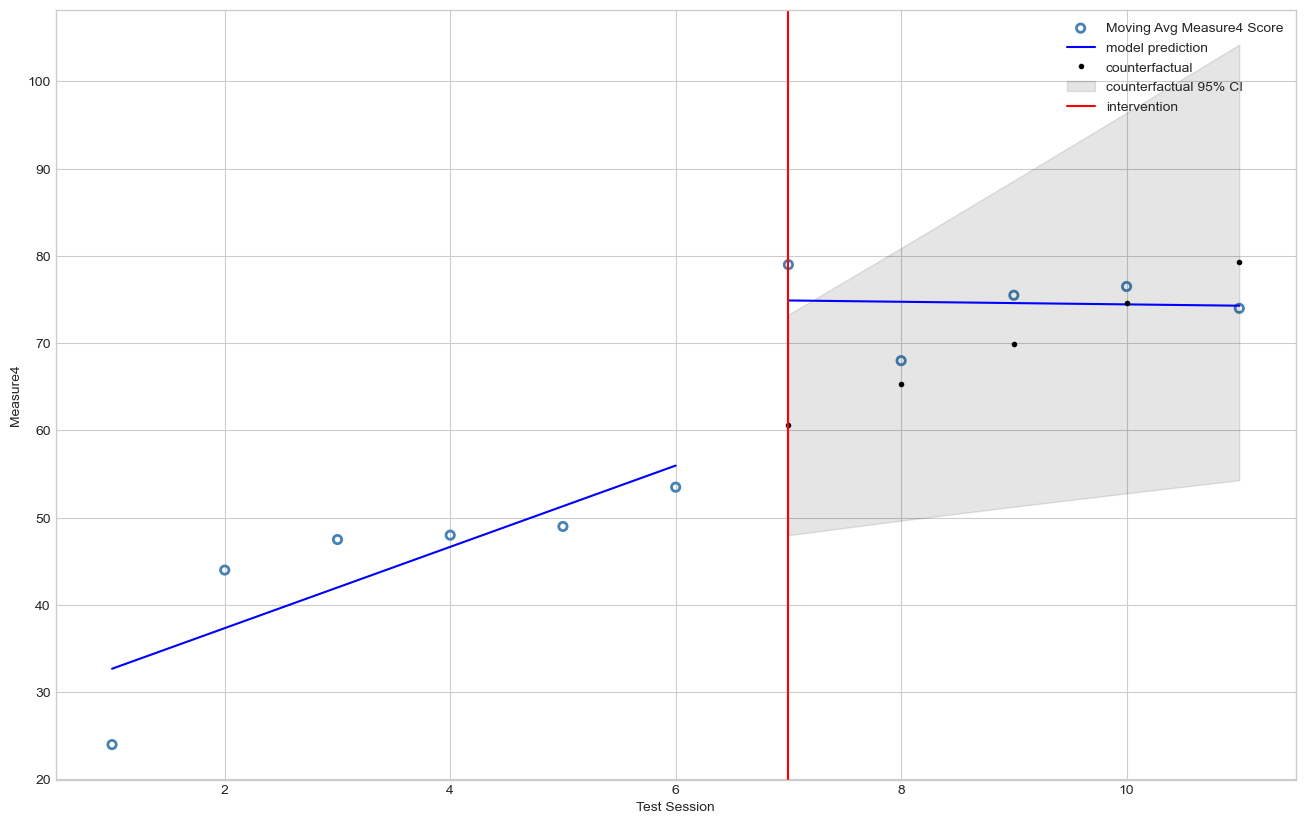

using measure Measure5
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure5   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.9032
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.486
Time:                        22:57:24   Log-Likelihood:                -48.695
No. Observations:                  11   AIC:                             105.4
Df Residuals:                       7   BIC:                             107.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


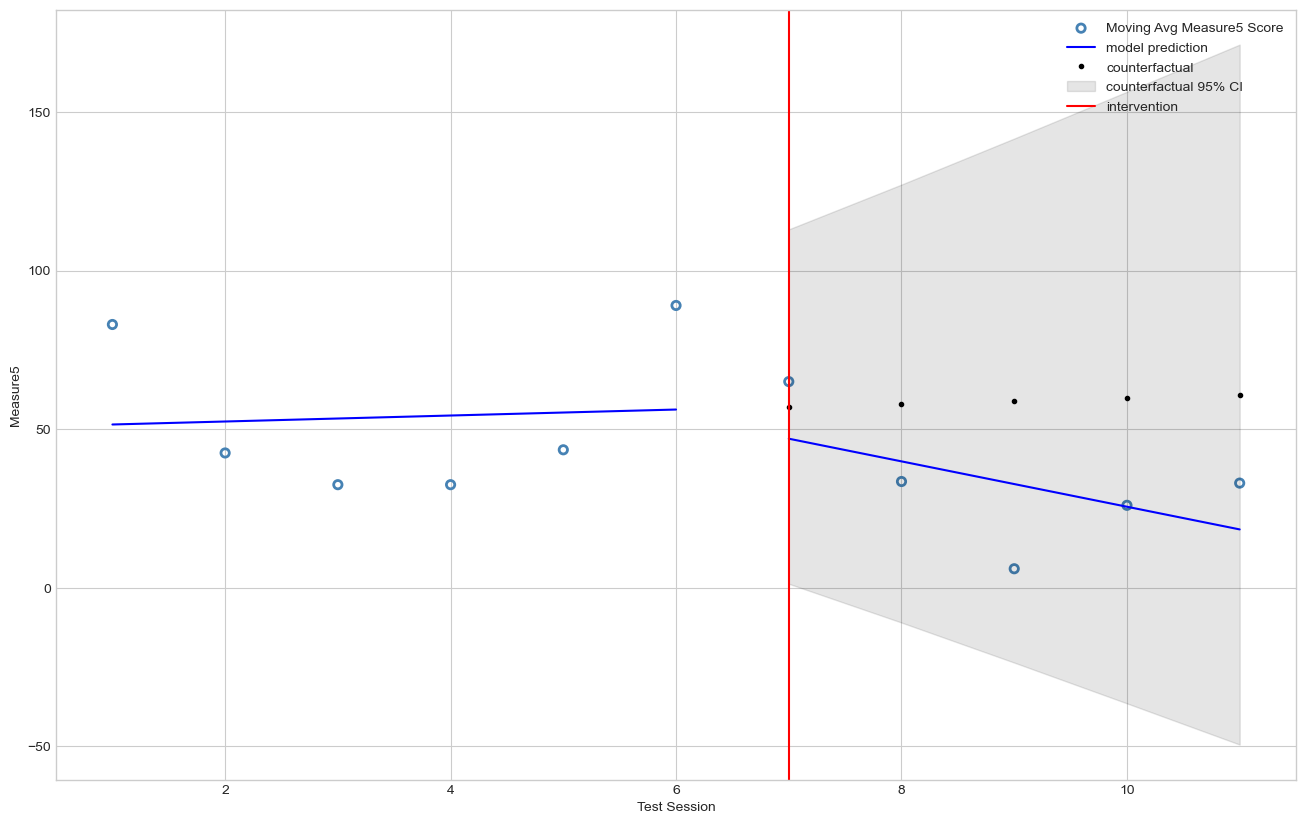

    Subject  Measure1  Measure2  Measure3  Measure4  Measure5  TestPhase  \
43        5         2        23        11        18        97          0   
44        5        76        32        95        36        14          0   
45        5        49        47        61        57         4          0   
46        5        35        18        61        35        36          0   
47        5        44        24        12         5        13          1   
48        5        17        91        96        89        97          1   

   SessionLabel2 SessionLabel  LastTreatmentSession  InTreatmentSessionNumber  \
43            P1           P4                     0                       0.0   
44            P2           P3                     0                       0.0   
45            P3           P2                     0                       0.0   
46            P4           P1                     0                       0.0   
47            F1           F2                     0           

D:\andre\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


                            OLS Regression Results                            
Dep. Variable:         rmean_Measure1   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                 -0.094
Method:                 Least Squares   F-statistic:                    0.8566
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.578
Time:                        22:57:24   Log-Likelihood:                -23.454
No. Observations:                   6   AIC:                             54.91
Df Residuals:                       2   BIC:                             54.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

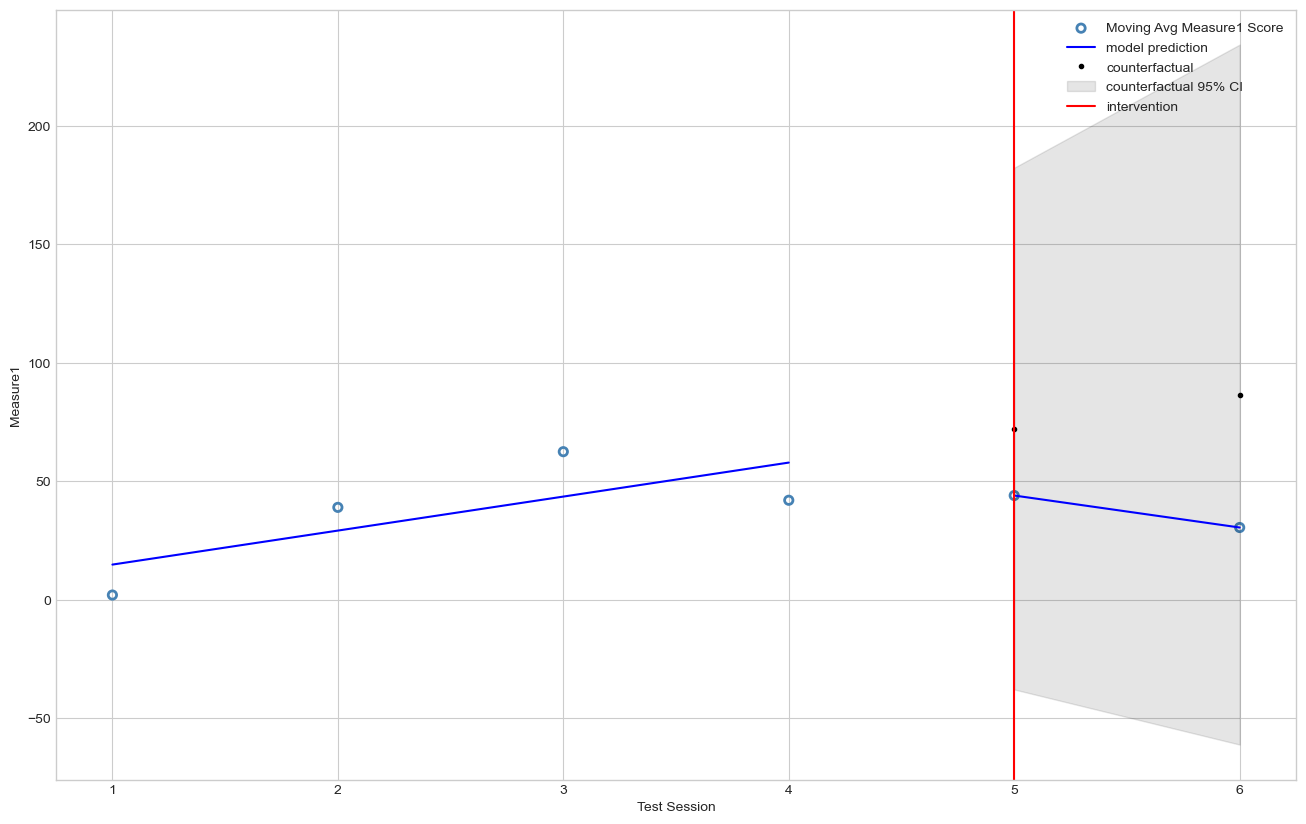

using measure Measure2
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure2   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     7.626
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.118
Time:                        22:57:24   Log-Likelihood:                -15.805
No. Observations:                   6   AIC:                             39.61
Df Residuals:                       2   BIC:                             38.78
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


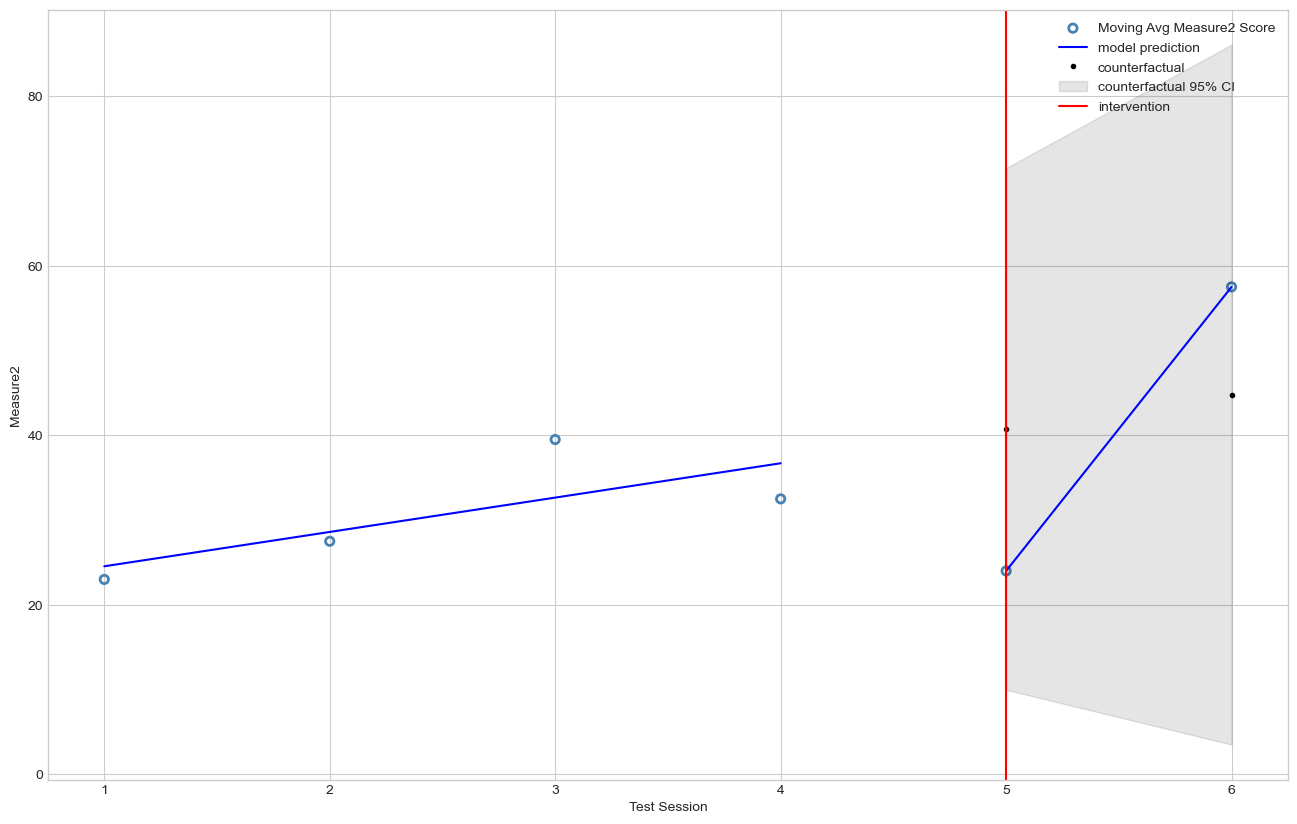

D:\andre\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


using measure Measure3
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure3   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     2.095
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.339
Time:                        22:57:24   Log-Likelihood:                -23.551
No. Observations:                   6   AIC:                             55.10
Df Residuals:                       2   BIC:                             54.27
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

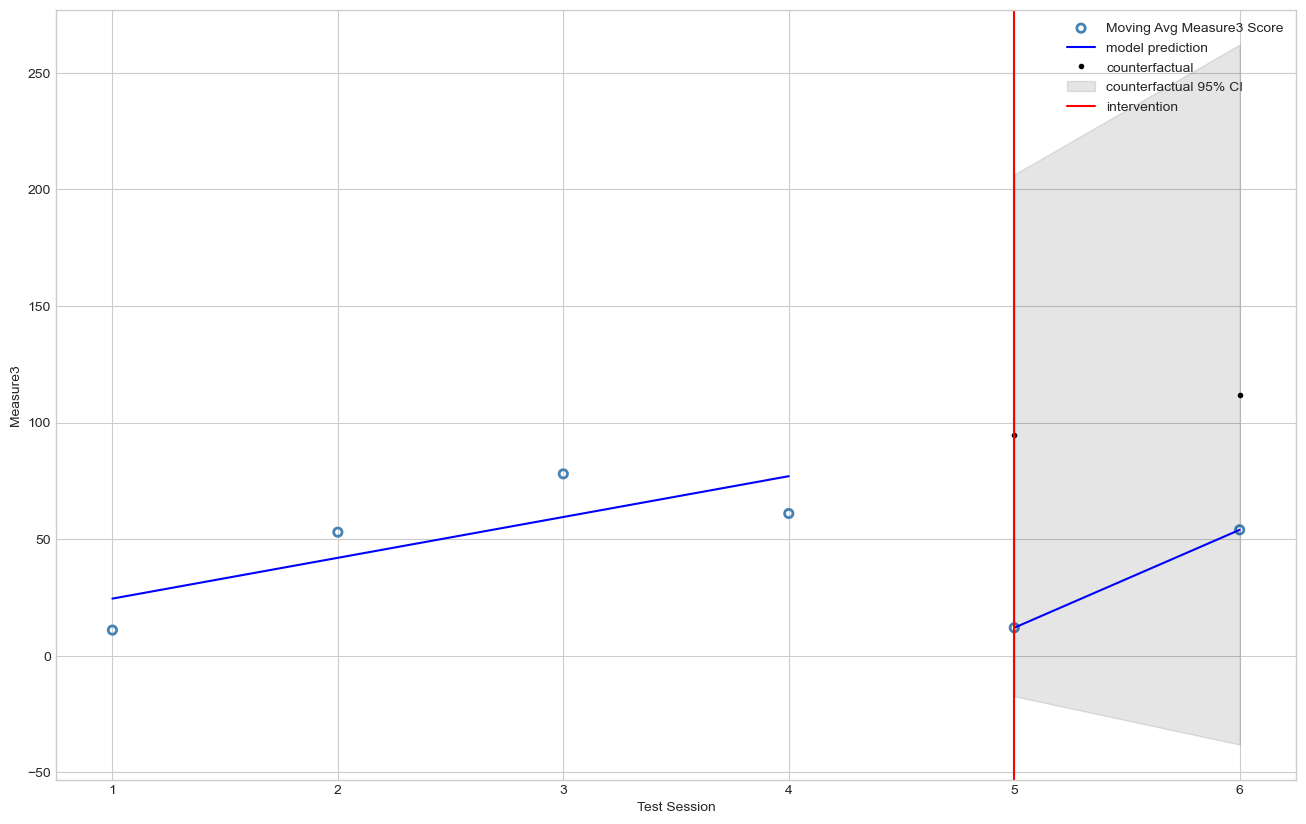

using measure Measure4
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure4   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     14.58
Date:                Wed, 16 Aug 2023   Prob (F-statistic):             0.0648
Time:                        22:57:24   Log-Likelihood:                -15.844
No. Observations:                   6   AIC:                             39.69
Df Residuals:                       2   BIC:                             38.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


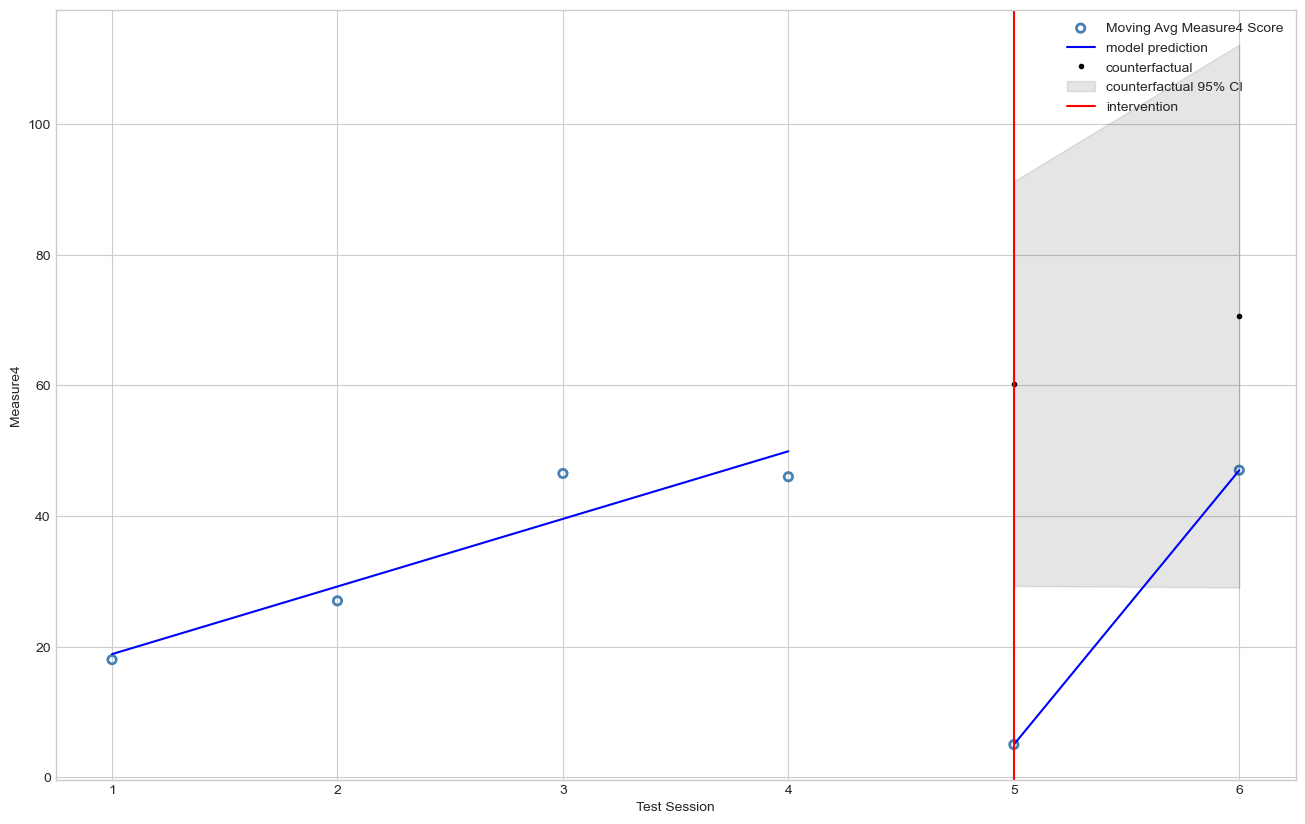

using measure Measure5
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure5   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     3.697
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.220
Time:                        22:57:24   Log-Likelihood:                -23.493
No. Observations:                   6   AIC:                             54.99
Df Residuals:                       2   BIC:                             54.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1794124490.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


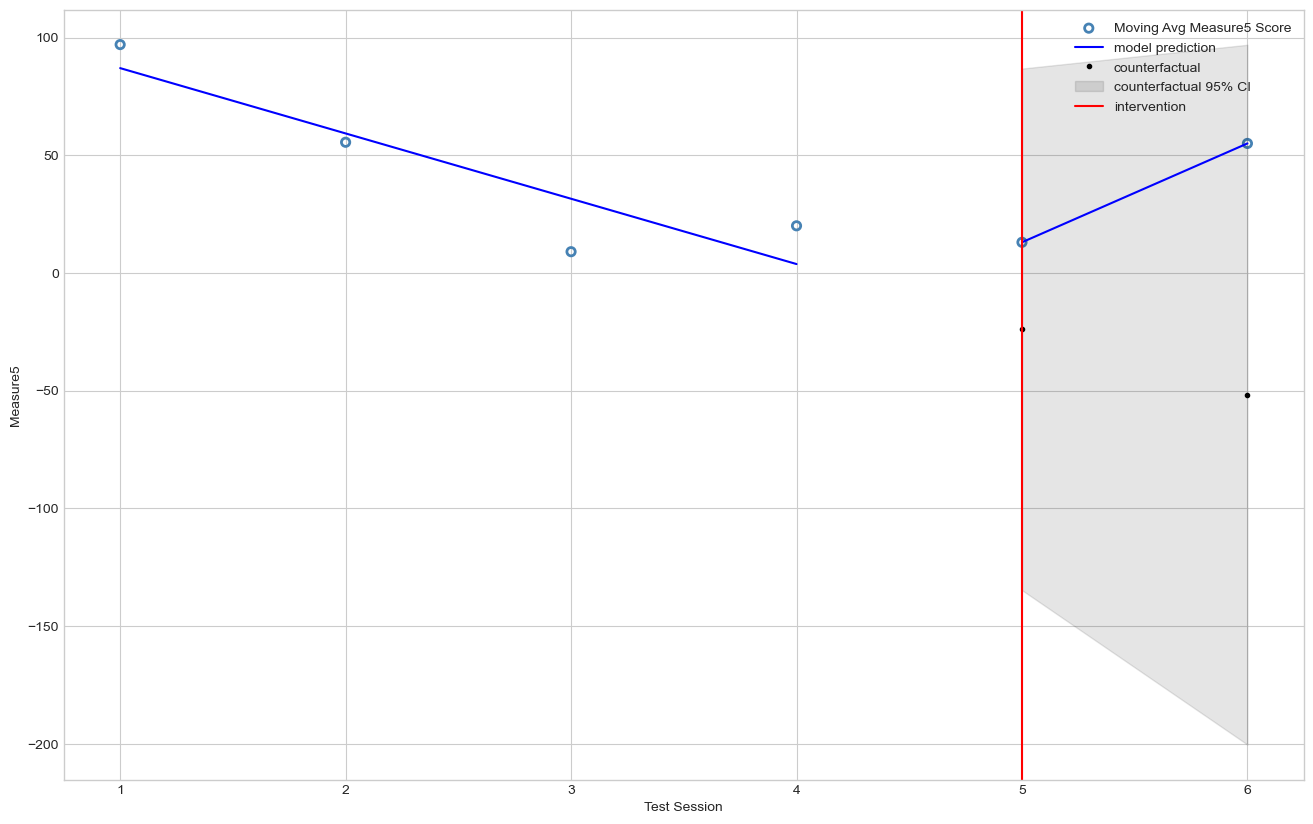

In [33]:
#A little setup to allow us to do nested assignment
from collections import defaultdict
model = defaultdict(dict)
res = defaultdict(dict)

#import models

import statsmodels.formula.api as smf

# time for big loops!
for subject in subjects:
     print(df[df['Subject']==subject])
     subdf = df[df['Subject']==subject]
     subdf = subdf[subdf['SessionLabel2'].str.contains("P|F")==True] #get InTreatment and pre-
     subdf = subdf[['Subject','TestPhase','TestSessionNo','SessionLabel2','InTreatmentSessionNumber',*measures]]
     subdf = subdf.set_index(['TestSessionNo'],drop=False)
    
     for measure in measures:
        print('using measure '+measure)
         #rolling_plot
        subdf['rmean_'+measure]=rolling_plot_AT(subdf,measure,noplot=True)
        subdf.reset_index(drop=True,inplace=True)
    
        ##Ordinary least squares for effect of "Test Phase"
        model[subject][measure] = smf.ols(formula='rmean_'+measure+' ~ TestSessionNo + TestPhase + InTreatmentSessionNumber', data=subdf)
        res[subject][measure] = model[subject][measure].fit()
        print(res[subject][measure].summary())

        #Plot
        counterfactual_plot_AT(res[subject][measure],subdf,measure)

We want to put some of these regression parameters in excel -- the regression slopes, the step (level change) between treatment periods, and pvals for all of this.

In [35]:
#Now we're going to put this in a spreadsheet so we can inspect or import this data elsewhere.

#Below we retrieve parameters from our model from statistics performed on each measure,
#  and then we'll make one sheet for each measure containing these parameters

# 'res' is your dictionary containing the data
checkdf = pd.DataFrame.from_dict(res).stack().to_frame()
checkdf = pd.DataFrame(checkdf[0].values.tolist(), index=checkdf.index)

#grab parameters and pvals from the model
checkdf[1] = checkdf[0].map(lambda mod: mod.params[1])
checkdf[2] = checkdf[0].map(lambda mod: mod.params[2])
checkdf[3] = checkdf[0].map(lambda mod: mod.params[3])

checkdf[4] = checkdf[0].map(lambda mod: mod.pvalues[1])
checkdf[5] = checkdf[0].map(lambda mod: mod.pvalues[2])
checkdf[6] = checkdf[0].map(lambda mod: mod.pvalues[3])
checkdf[7] = checkdf[0].map(lambda mod: mod.f_pvalue)

#Make column names that correspond to the parameters we grabbed from the model
checkdf.columns = ['Model','PreTreatmentSlope', 'Step', 'SlopeChange', 'pval_PreTreatmentSlope', 'pval_Step', 'pval_SlopeChange', 'pval_Overall_Model']

# Create an Excel writer object
excel_writer = pd.ExcelWriter('Spline_Model_Parameters--Output.xlsx', engine='xlsxwriter')

# Collapse levels of columns and rearrange the columns
checkdf = checkdf.unstack(level=0)

#save the level you want to arrange sheets by
extracted_columns = checkdf.columns.get_level_values(1)
xlcols=extracted_columns.unique().to_list()

#combine the generic model names above with the 5 measure names
checkdf.columns = checkdf.columns.map('{0[1]}|{0[0]}'.format)

# Iterate through each unique column prefix and create a separate sheet
for prefix in xlcols: #still not sure this loop works correct, like all the prefix column vars
    prefix_columns = [col for col in checkdf.columns if col.startswith(prefix)]
    prefix_df = checkdf[prefix_columns]
    prefix_df.to_excel(excel_writer, sheet_name=prefix)

# Save the Excel file
excel_writer.save()

C:\Users\andre\AppData\Local\Temp\ipykernel_24584\1939825783.py:43: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()


**And there you have it!** 

Summary/intervention statistics from a linear model with parameters for treatment time course data!

Lastly, we can put our beautiful plots in a PDF. The data was randomly generated, and it's disturbing almost how linear it is after using the rolling mean...


In [36]:
from matplotlib.backends.backend_pdf import PdfPages

# Modified function with PdfPages integration
def counterfactual_plot_AT_to_pdf(pdf, res, df, measure1,title1): 
    start = df.loc[df['TestPhase'] == 1].index[0]
    end = df.loc[df['TestPhase'] == 1].index[-1]
    beta = res.params
    predictions = res.get_prediction(df)
    summary = predictions.summary_frame(alpha=0.05)

    y_pred = predictions.predicted_mean

    cf_df = df.copy()
    cf_df["TestPhase"] = 0.0
    cf_df["InTreatmentSessionNumber"] = 0.0

    cf = res.get_prediction(cf_df).summary_frame(alpha=0.05)

    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 10))

    ax.scatter(df["TestSessionNo"], df['rmean_' + measure1], facecolors='none', edgecolors='steelblue', label='Moving Avg ' + measure1 + ' Score', linewidths=2)
    ax.plot(df["TestSessionNo"][:start], y_pred[:start], 'b-', label="model prediction")
    ax.plot(df["TestSessionNo"][start:], y_pred[start:], 'b-')
    ax.plot(df["TestSessionNo"][start:], cf['mean'][start:], 'k.', label="counterfactual")
    ax.fill_between(df["TestSessionNo"][start:], cf['mean_ci_lower'][start:], cf['mean_ci_upper'][start:], color='k', alpha=0.1, label="counterfactual 95% CI");
    ax.axvline(x=start + 1, color='r', label='intervention')

    ax.legend(loc='best')
    plt.xlabel("Test Session")
    plt.ylabel(measure1)
    plt.title(title1)

    pdf.savefig(fig)
    plt.close(fig)


In [38]:
# and we need to use a sliiiightly modified version of our loop
with PdfPages('Regression_Plots--Output.pdf') as pdf:
    for subject in subjects:
         print(df[df['Subject']==subject])
         subdf = df[df['Subject']==subject]
         subdf = subdf[subdf['SessionLabel2'].str.contains("P|F")==True] #get InTreatment and pre-
         subdf = subdf[['Subject','TestPhase','TestSessionNo','SessionLabel2','InTreatmentSessionNumber',*measures]]
         subdf = subdf.set_index(['TestSessionNo'],drop=False)
    
         for measure in measures:
            print('using measure '+measure)
            #rolling_plot
            subdf['rmean_'+measure]=rolling_plot_AT(subdf,measure,noplot=True)
            subdf.reset_index(drop=True,inplace=True)
        
            ##Ordinary least squares for effect of "Test Phase"
            model[subject][measure] = smf.ols(formula='rmean_'+measure+' ~ TestSessionNo + TestPhase + InTreatmentSessionNumber', data=subdf)
            res[subject][measure] = model[subject][measure].fit()
            print(res[subject][measure].summary())
    
            #Plot
            counterfactual_plot_AT_to_pdf(pdf,res[subject][measure],subdf,measure,str(subject)+' '+measure)

   Subject  Measure1  Measure2  Measure3  Measure4  Measure5  TestPhase  \
0        1        95        14         3        93        39          0   
1        1        28        15        51        54        28          0   
2        1        70        77        13        35        63          0   
3        1         5        65        45        62        50          0   
4        1        38        62        76        53        63          0   
5        1        25        85        29         4        75          0   
6        1        56        23        20        64        43          1   
7        1        84         7        49        26        64          1   
8        1        33        56        37        51        81          1   
9        1        70        59        33        27        72          1   

  SessionLabel2 SessionLabel  LastTreatmentSession  InTreatmentSessionNumber  \
0            P1           P6                     0                       0.0   
1            P

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


using measure Measure2
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure2   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     10.46
Date:                Wed, 16 Aug 2023   Prob (F-statistic):            0.00849
Time:                        23:25:30   Log-Likelihood:                -36.391
No. Observations:                  10   AIC:                             80.78
Df Residuals:                       6   BIC:                             81.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to 

using measure Measure4
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure4   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     6.470
Date:                Wed, 16 Aug 2023   Prob (F-statistic):             0.0261
Time:                        23:25:30   Log-Likelihood:                -36.004
No. Observations:                  10   AIC:                             80.01
Df Residuals:                       6   BIC:                             81.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to 

using measure Measure2
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure2   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     1.552
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.332
Time:                        23:25:30   Log-Likelihood:                -29.837
No. Observations:                   8   AIC:                             67.67
Df Residuals:                       4   BIC:                             67.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to th

using measure Measure5
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure5   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.9041
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.514
Time:                        23:25:31   Log-Likelihood:                -28.938
No. Observations:                   8   AIC:                             65.88
Df Residuals:                       4   BIC:                             66.19
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to t

using measure Measure3
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure3   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     1.662
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.273
Time:                        23:25:31   Log-Likelihood:                -33.530
No. Observations:                  10   AIC:                             75.06
Df Residuals:                       6   BIC:                             76.27
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to 

    Subject  Measure1  Measure2  Measure3  Measure4  Measure5  TestPhase  \
31        4         3        29        34        24        83          0   
32        4        10        69        57        64         2          0   
33        4        65        61        46        31        63          0   
34        4        15        91        10        65         2          0   
35        4         4        32        24        33        85          0   
36        4        96        17        55        74        93          0   
37        4         5        47        91        79        65          1   
38        4        72        56        24        57         2          1   
39        4        86        25        42        94        10          1   
40        4         3        41        84        59        42          1   
41        4        75        33        23        89        24          1   

   SessionLabel2 SessionLabel  LastTreatmentSession  InTreatmentSessionNumber  \
31    

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to 

using measure Measure4
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure4   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     29.10
Date:                Wed, 16 Aug 2023   Prob (F-statistic):           0.000252
Time:                        23:25:31   Log-Likelihood:                -32.347
No. Observations:                  11   AIC:                             72.69
Df Residuals:                       7   BIC:                             74.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
D:\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to 

using measure Measure2
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure2   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     7.626
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.118
Time:                        23:25:32   Log-Likelihood:                -15.805
No. Observations:                   6   AIC:                             39.61
Df Residuals:                       2   BIC:                             38.78
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
D:\andre\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are de

using measure Measure5
                            OLS Regression Results                            
Dep. Variable:         rmean_Measure5   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     3.697
Date:                Wed, 16 Aug 2023   Prob (F-statistic):              0.220
Time:                        23:25:32   Log-Likelihood:                -23.493
No. Observations:                   6   AIC:                             54.99
Df Residuals:                       2   BIC:                             54.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

D:\andre\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\andre\AppData\Local\Temp\ipykernel_24584\3866988159.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
